In [1]:
from shared import graph, stats_utils
from src_draft.utils import LOW_IMP_FEATURES
import shared.ml_config_core as ml_config_core
import pandas as pd
from shared.ml_config_core import ModelConfigsCollection
from shared.ml_config_runner import run_tuning_for_configs_collection
from shared.definitions import TuningResult
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from pandas import CategoricalDtype
from Draft import feature_builder_v2

import importlib
from matplotlib import pyplot as plt
import src_draft.utils as shared_utils
import seaborn as sns
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
importlib.reload(shared_utils)

shared_utils.pandas_config(pd)
shared_utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")

In [3]:
importlib.reload(feature_builder_v2)
features_matrix = feature_builder_v2.load_datasets_and_prepare_features(
    drop_meta_data=True, ds_type=feature_builder_v2.DatasetType.FULL
)

C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 

Appending previous history
Full DS size: 307511


### Exploratory Analysis

In [4]:
conditions = [
    features_matrix["PrevRatioRejectedAccepted"].isna(),
    features_matrix["PrevRatioRejectedAccepted"] == 0,
    features_matrix["PrevRatioRejectedAccepted"] <= 0.25,
    features_matrix["PrevRatioRejectedAccepted"] > 0.25,
]

conditions_2 = [
    features_matrix["PrevRatioRejectedAccepted"].isna(),
    features_matrix["PrevRatioRejectedAccepted"] == 0,
    features_matrix["PrevRatioRejectedAccepted"] > 0,
]

choices = ["No Previous App.", "All Accepted", "< 25% Rejected", "> 25% Rejected"]
choices_2 = ["No Previous App.", "All Accepted", "> 0% Rejected"]

features_matrix["PrevRatioRejectedAccepted_cats"] = np.select(
    conditions, choices, default="No Previous App"
)
features_matrix["PrevRatioRejectedAccepted_cats_2"] = np.select(
    conditions, choices, default="No Previous App"
)

features_matrix["PrevRatioRejectedAccepted_cats"] = features_matrix[
    "PrevRatioRejectedAccepted_cats"
].astype("category")
features_matrix["PrevRatioRejectedAccepted_cats_2"] = features_matrix[
    "PrevRatioRejectedAccepted_cats_2"
].astype("category")

This notebook includes the analysis of selected variables (based on their importance (based on SHAP values) at predicting the target variable) and their relationships. Individual analysis of each variable is available in the `EDA_appendices` notebook.

In [5]:
add_features = [
    "PrevRatioRejectedAccepted_cats",
    "PrevRatioRejectedAccepted_cats_2",
    "TARGET",
]
features_matrix_only_high_imp = features_matrix[
    shared_utils.HIGH_IMP_FEATURES + add_features
]
features_matrix_any_imp = features_matrix[shared_utils.ANY_IMP_FEATURES + add_features]

##### Dataset Summary

NaN Values by Column:

In [6]:
# TODO impute missing values, either
stats_utils.nan_summary(features_matrix_only_high_imp)

Total NaN Values  Proportion NaN (%)
ExtSource2                                    660                 0.0
ExtSource3                                  60965                20.0
AmtGoodsPrice                                 278                 0.0
ExtSource1                                 173378                56.0
OwnCarAge                                  202929                66.0
MeanbureauamtCreditSumDebt                  51380                17.0
AmtAnnuity                                     12                 0.0
PrevAvgYieldGroup                           18945                 6.0
PrevCreditReceivedRequestedDiff             16454                 5.0
PrevAmtDownPaymentSum                       16454                 5.0
MaxbureaudaysCredit                         44020                14.0
MaxbureaudaysCreditEnddate                  46269                15.0
OccupationType                              96391                31.0
MaxbureaudaysEnddateFact                    77156                25.0
MeanbureauamtCreditSum                      44021                14.0

##### Duplicates

In [7]:
duplicated_row_count = features_matrix[features_matrix.duplicated(keep=False)].shape[0]
display(f"Duplicated Values: {duplicated_row_count}")

'Duplicated Values: 0'

In [8]:
display(f"Total Columns: {len(features_matrix.columns)}")

'Total Columns: 229'

#### Correlations

Because we  have such a large number of columns we have only included features which have an importance value { > `0.04` } with our final LGBM model:

V:\projects\ppuodz-ML.4.1\shared\graph.py:1262: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr = round(corr.applymap(pd.to_numeric), 2)


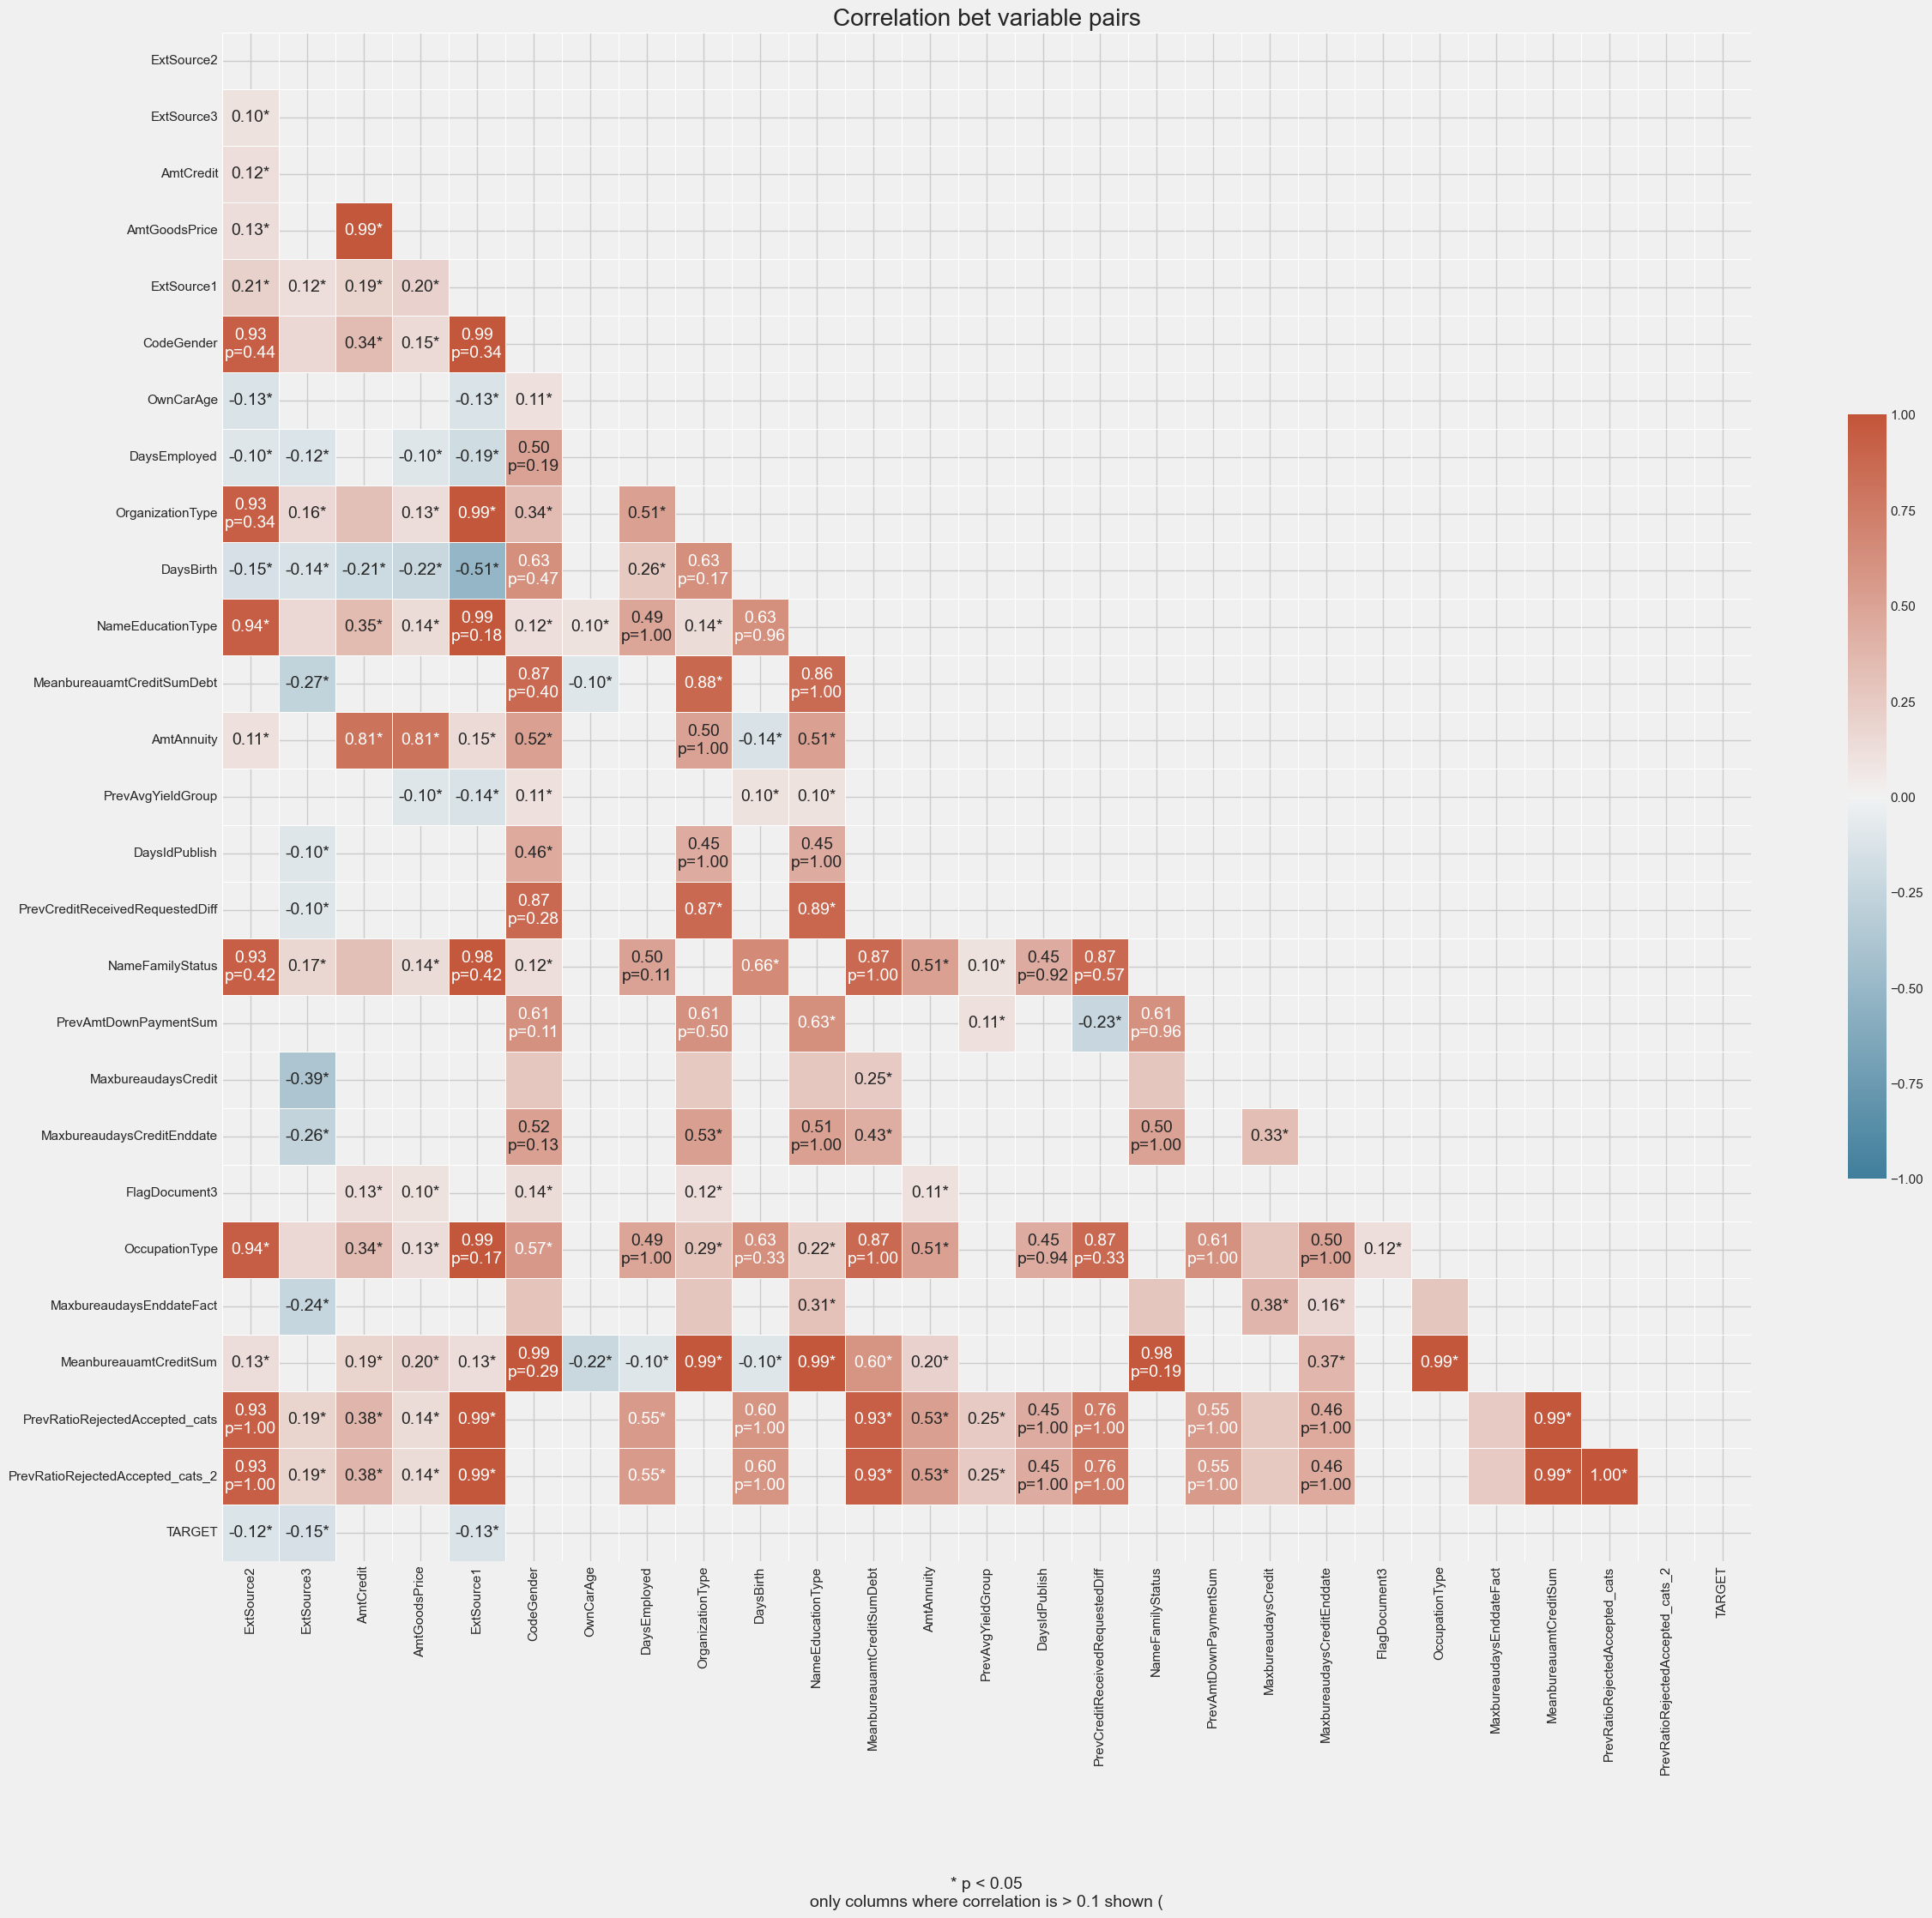

In [9]:
# TODO impute missing values (mean for numerical, proportion sampling for cat)
# OR inside correlation check just drop rows with missing values for tested columns
importlib.reload(graph)

features_matrix_any_imp_no_nan = features_matrix_only_high_imp.dropna(axis=0, how="any")
features_matrix_any_imp_no_nan = features_matrix_any_imp_no_nan.apply(
    lambda col: (
        col.astype(float)
        if col.dtype == "Float64"
        else col.astype(int) if col.dtype == "Int64" else col
    )
)

graph.render_corr_matrix_based_on_type(features_matrix_any_imp_no_nan)

The `TARGET` variable (loans with payment difficulties) is most correlated with credit ratings obtained from external sources. The correlation is very weak but still significant.

```
Because the datatypes of features vary we had to use different methods to measure the strength and significance of each pair:

- Chi-Squared Test: Assesses independence between two categorical variables.  For bool-bool pairs due to categorical nature.

- Point Biserial Correlation: Measures correlation between a binary and a continuous variable. For bool-numerical pairs to account for mixed data types.

- Spearman's Rank Correlation: Assesses monotonic relationship between two continuous variables. Used for numerical-numerical pairs (for non-normally distributed data).

Since the Chi-Squared test outputs an unbound statistic/value which can't be directly compared to  pointbiserialr or Spearman Rank we have converted them to a  ` Cramér's V:` value which is normalized between 0 and 1. This was done to make the values in the matrix more uniform however we must note that Cramér's V and Spearman's correlation coefficients are fundamentally different statistics and generally can't be directly compared.
```

##### Corelation With the Target Variable

Our target variable `TARGET` show whether the given application had any late payments (value = 1), we can see that no single feature is strongly correlated with it:

In [10]:
correlation_results = []
for col in features_matrix_any_imp_no_nan.columns:
    if col == "TARGET":
        continue
    x = features_matrix_any_imp_no_nan["TARGET"]
    y = features_matrix_any_imp_no_nan[col]

    corr_value, p_value = stats_utils.correlation_test(x, y)

    correlation_results.append(
        {"Column": col, "Coefficient": corr_value, "P-Value": p_value}
    )
correlation_df = pd.DataFrame(correlation_results).set_index("Column")
correlation_df = correlation_df.loc[
    correlation_df["Coefficient"].abs().sort_values(ascending=False).index
]
correlation_df.round(3)

Coefficient  P-Value
Column                                                
ExtSource3                             -0.151    0.000
ExtSource1                             -0.131    0.000
ExtSource2                             -0.125    0.000
OccupationType                          0.073    0.000
PrevRatioRejectedAccepted_cats          0.071    0.000
PrevRatioRejectedAccepted_cats_2        0.071    0.000
DaysEmployed                            0.070    0.000
OrganizationType                        0.065    0.000
MaxbureaudaysCredit                     0.064    0.000
NameEducationType                       0.059    0.000
PrevCreditReceivedRequestedDiff         0.056    0.000
PrevAmtDownPaymentSum                  -0.052    0.000
OwnCarAge                               0.049    0.000
DaysBirth                               0.049    0.000
MeanbureauamtCreditSumDebt              0.045    0.000
MaxbureaudaysCreditEnddate              0.041    0.000
PrevAvgYieldGroup                       0.040    0.000
CodeGender                              0.040    0.000
FlagDocument3                           0.038    0.000
AmtGoodsPrice                          -0.031    0.000
DaysIdPublish                           0.030    0.000
NameFamilyStatus                        0.028    0.000
MaxbureaudaysEnddateFact                0.022    0.000
AmtCredit                              -0.020    0.001
MeanbureauamtCreditSum                 -0.017    0.005
AmtAnnuity                              0.000    0.979

In [11]:
features_matrix_only_imp_cat_cols = features_matrix_only_high_imp.select_dtypes(
    include="category"
).columns
features_matrix_target_cat = features_matrix_only_high_imp.copy()
features_matrix_target_cat["TARGET"] = features_matrix_target_cat["TARGET"].map(
    lambda x: "Default/Loan With Issues" if x == 1 else "No Issues"
)

The chart below shows the relationship between selected categorical variables and loan status. E.g. a significantly higher proportion of loans taken out by males had issues.

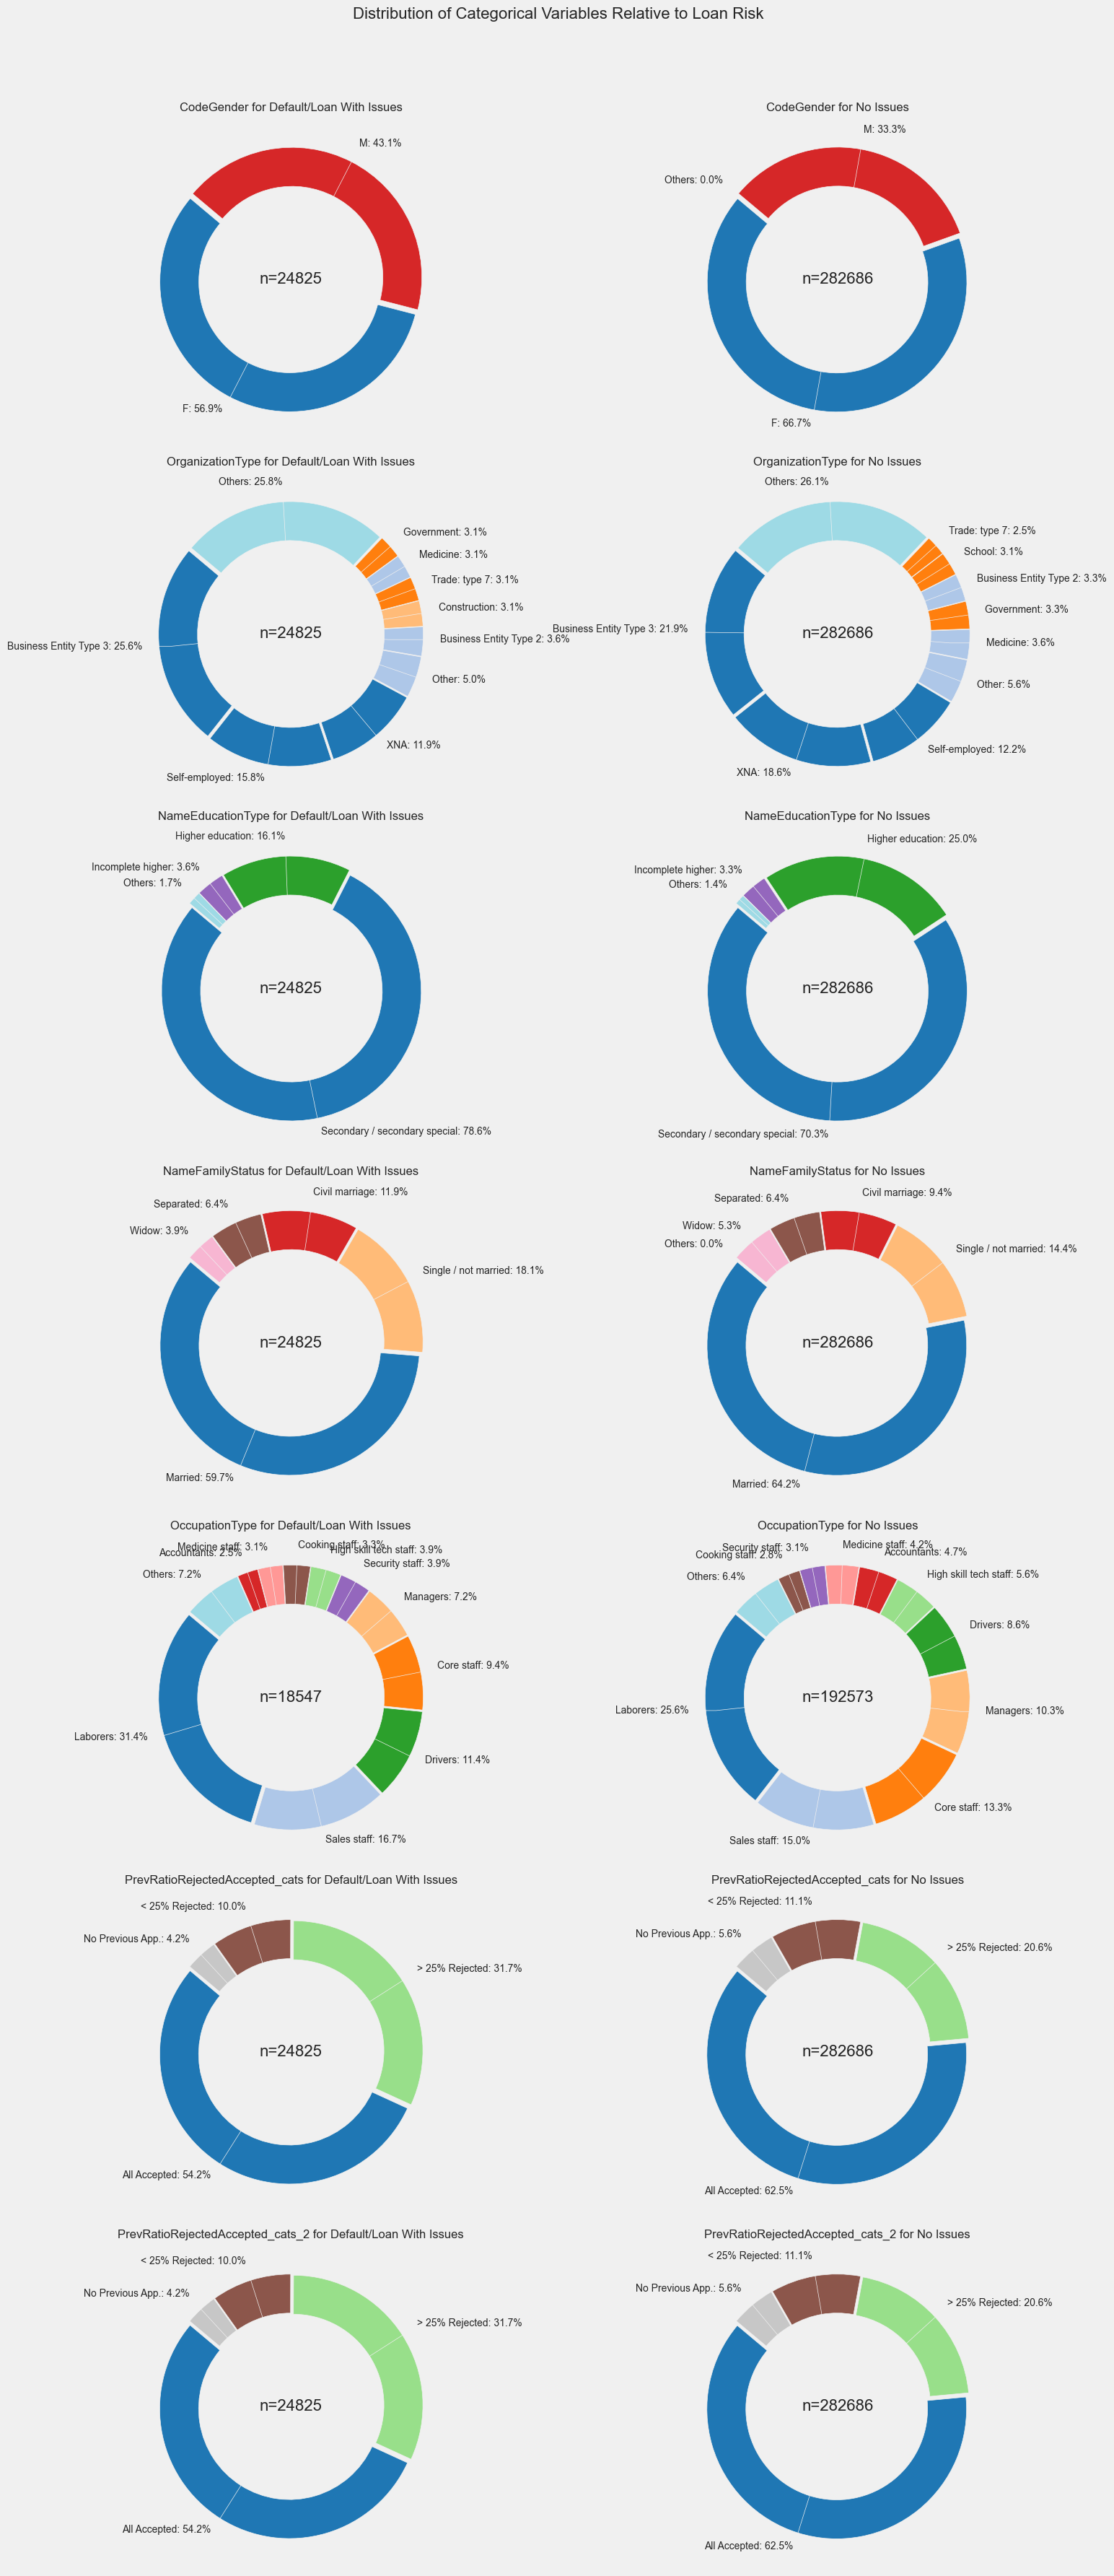

In [12]:
importlib.reload(graph)
graph.draw_distribution_pie_charts(
    features_matrix_target_cat,
    split_var="TARGET",
    include_cols=features_matrix_only_imp_cat_cols,
    title="Distribution of Categorical Variables Relative to Loan Risk",
    clean_tick_label=False,
)

In [13]:
features_matrix_with_bins = features_matrix_only_high_imp.copy()
numerical_cols = features_matrix_only_high_imp.select_dtypes(
    include=["int64", "float64", "Int64"]
).columns

for col in numerical_cols:
    if features_matrix_with_bins[col].nunique() < 5:
        features_matrix_with_bins[f"{col}_binned"] = features_matrix_with_bins[
            col
        ].astype("category")
    else:
        features_matrix_with_bins[f"{col}_binned"] = stats_utils.bin_and_label(
            features_matrix_with_bins[col], num_bins=4
        )
    features_matrix_with_bins[col] = features_matrix_with_bins[col]
import numpy as np

conditions = [
    features_matrix["TotalDefaults"] == 0,
    features_matrix["TotalDefaults"] >= 1,
    # features_matrix["TotalDefaults"] > 1
]

choices = ["No Defaults", "1 Defaulted Loans"]  # ,"> 1 defaulted loan"]
# choices = ['All Accepted', "> 0 Rejected"]
# choices = ['No Previous', '0', '> 0']

features_matrix_with_bins["TotalDefaults_cats"] = np.select(
    conditions, choices, default="WTF?"
).astype("object")

features_matrix_with_bins["Defaulted"] = features_matrix_with_bins["TARGET"].map(
    lambda x: "Yes" if x == 1 else "No"
)
features_matrix_with_bins.drop(columns=["TARGET", "TARGET_binned"], inplace=True)

In [14]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].dtype

CategoricalDtype(categories=['< 25% Rejected', '> 25% Rejected', 'All Accepted', 'No Previous App.'], ordered=False, categories_dtype=object)

#### Relationships Between Numerical and Categorical Variables

The charts below show pairs of numerical and categorical features (including some binned numerical features) that have a signficant relationships and at least a small effect size (`eta_squared`>0.01) based on the non-parametric Kruskal-Wallis Test (one-way ANOVA on ranks)  testing whether samples originate from the same distribution.

*`It's similar to the Mann–Whitney U test but allows comparing more than 2 groups`

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


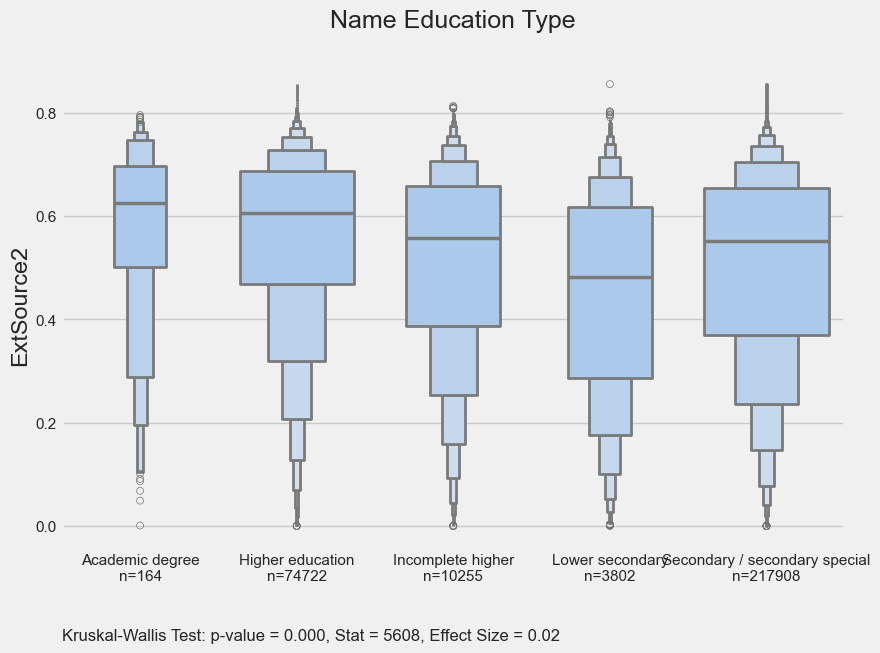

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


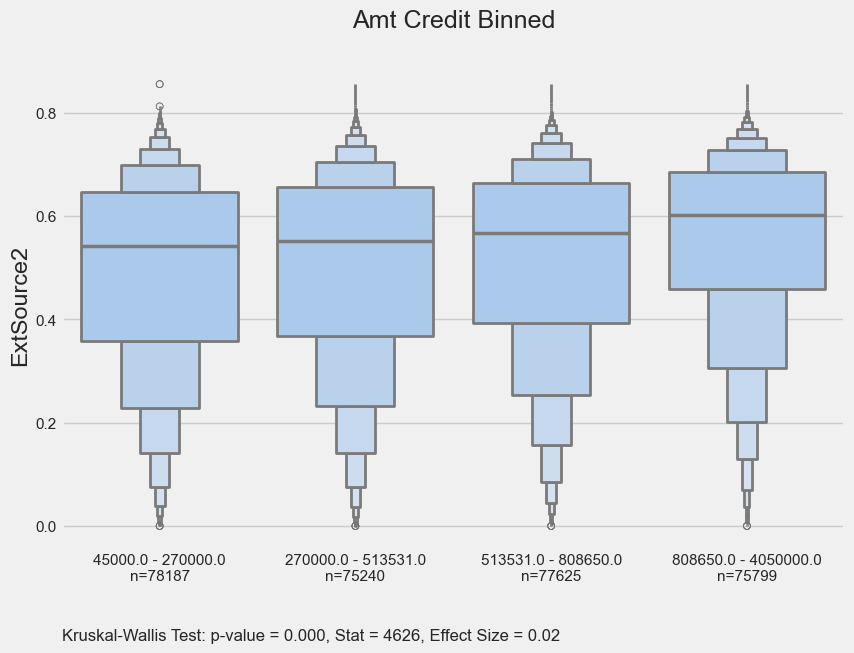

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


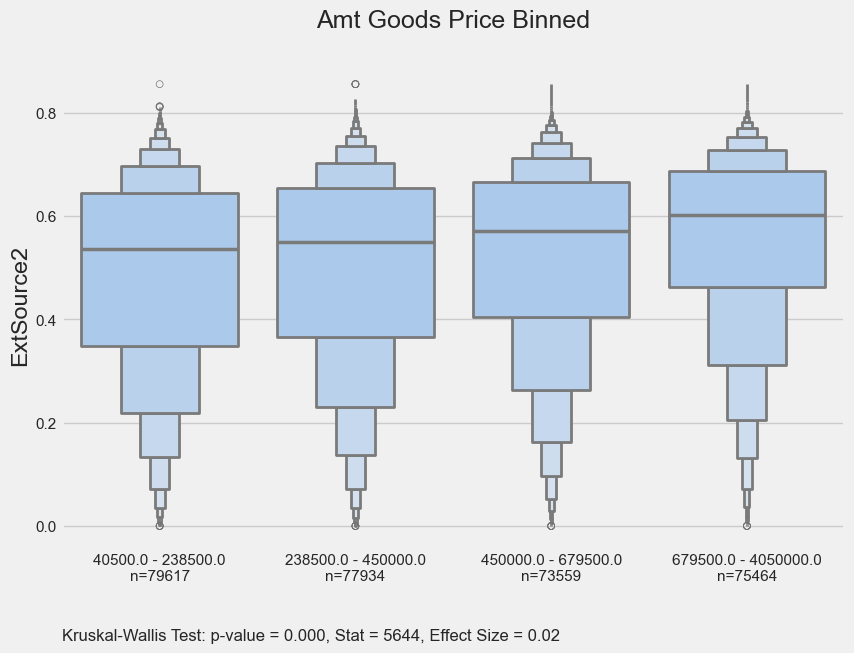

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


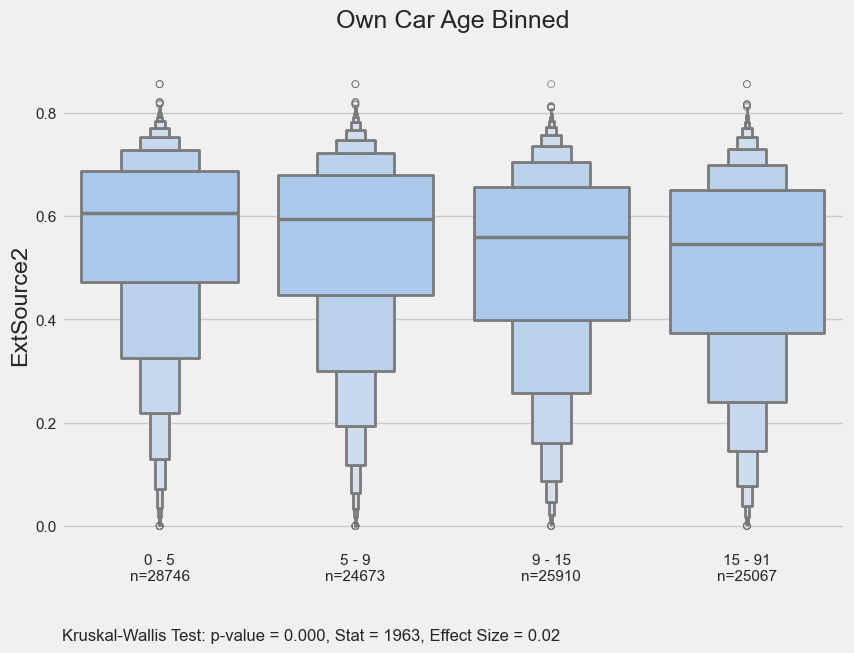

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


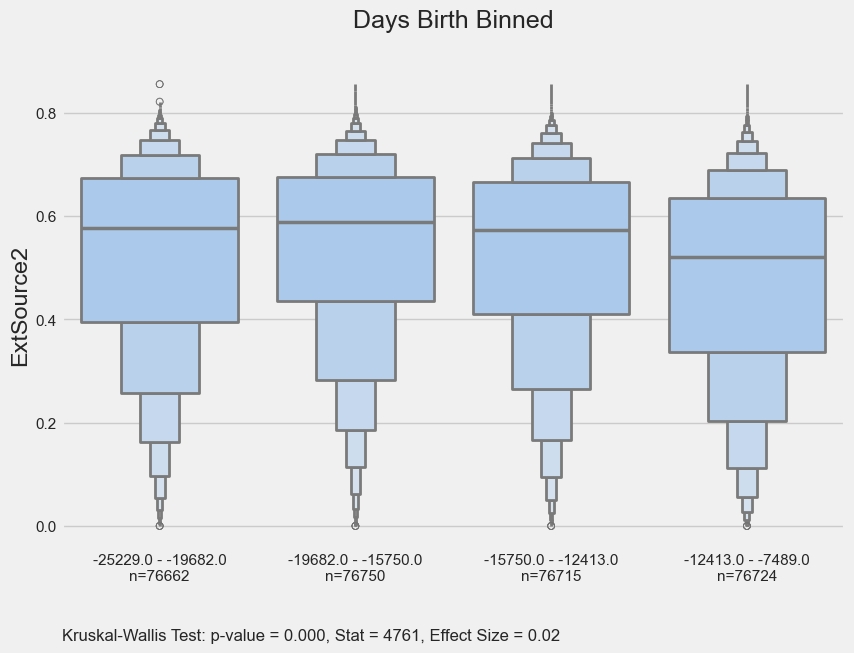

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


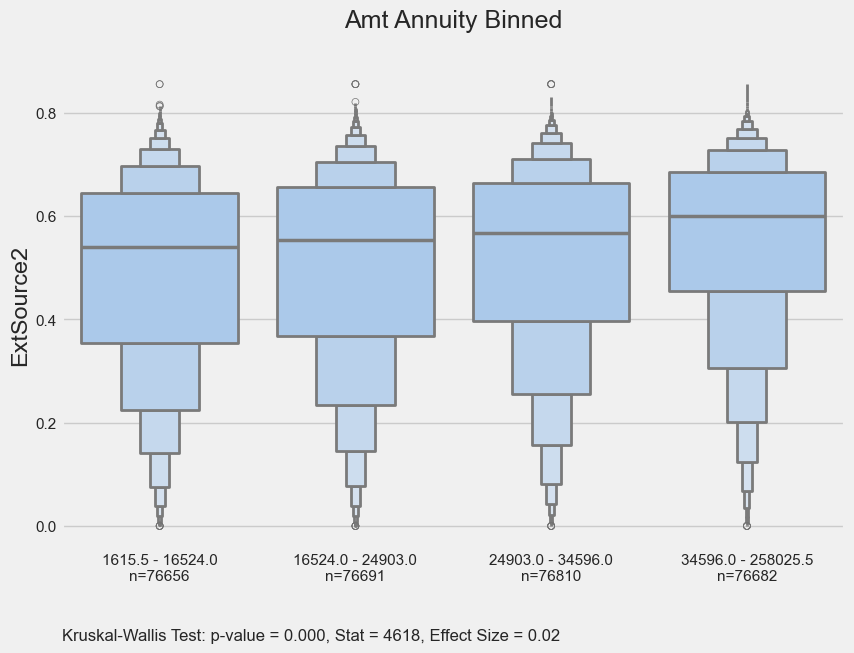

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


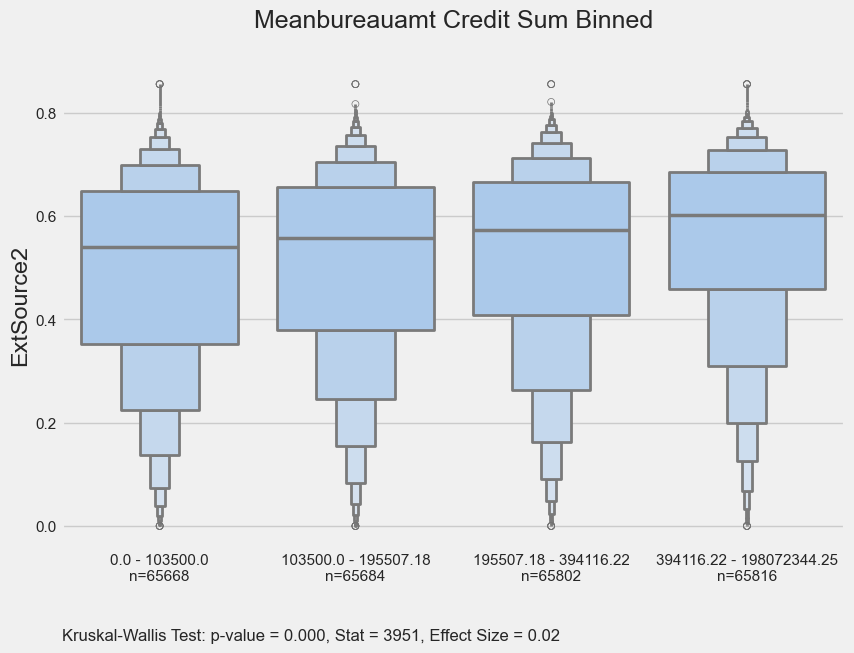

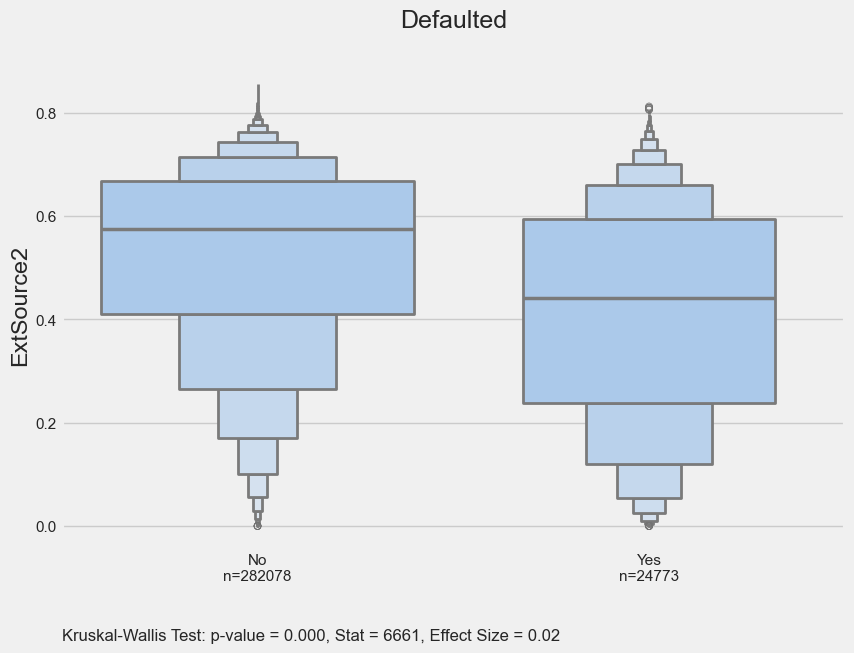

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


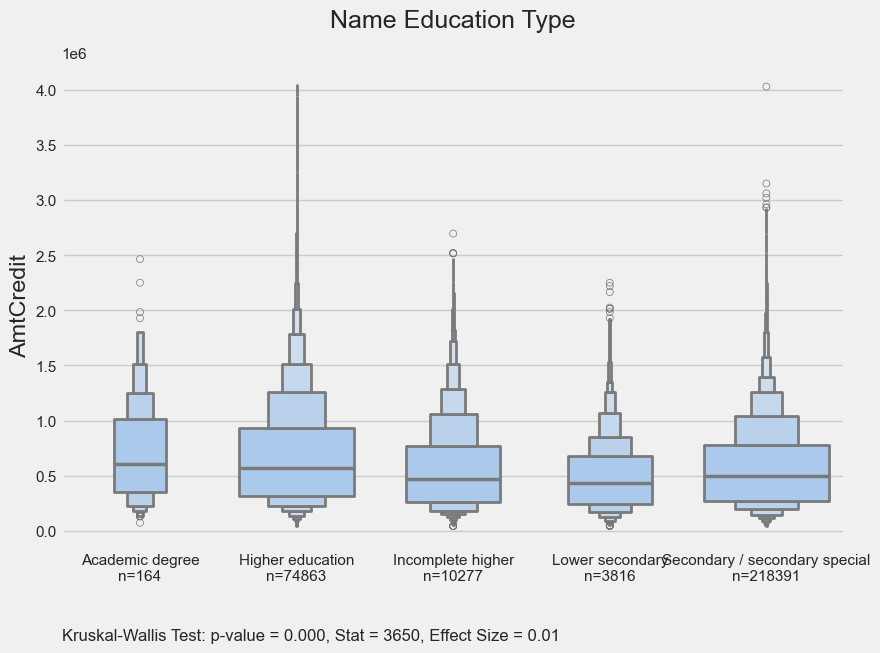

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


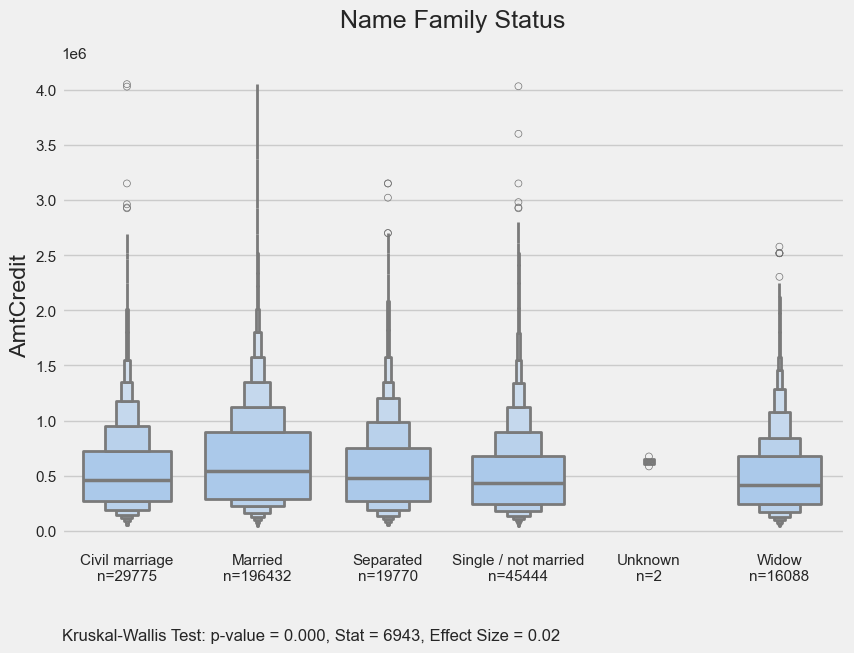

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


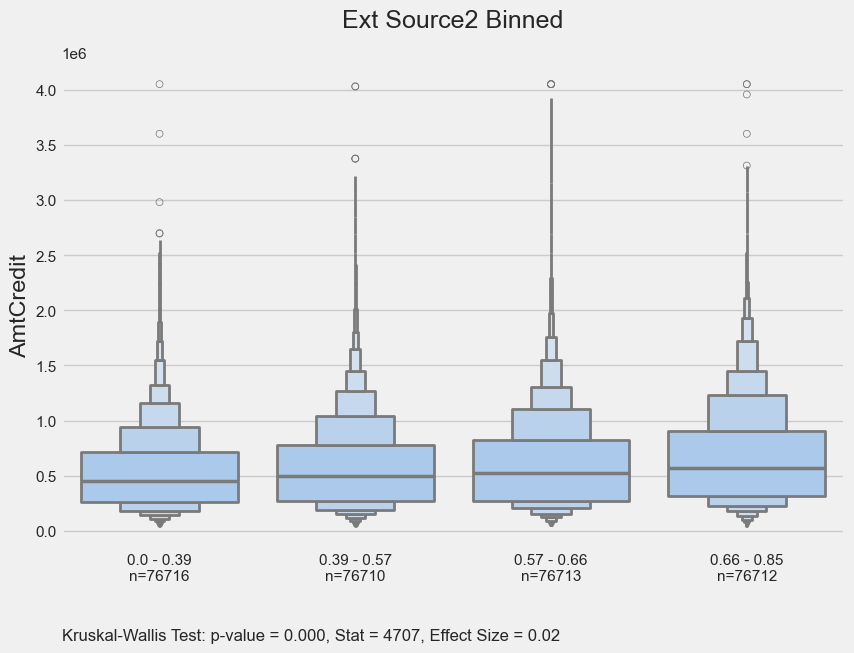

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


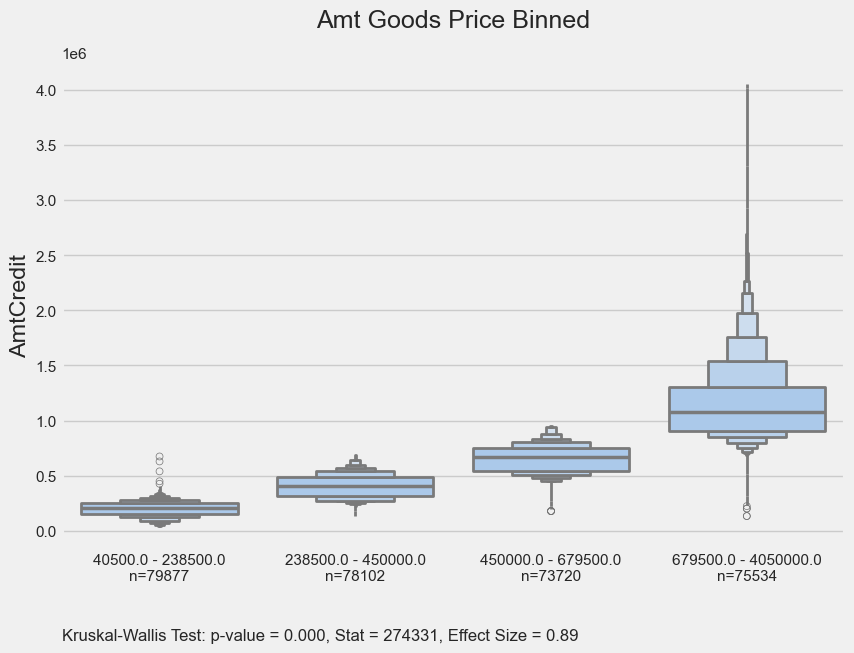

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


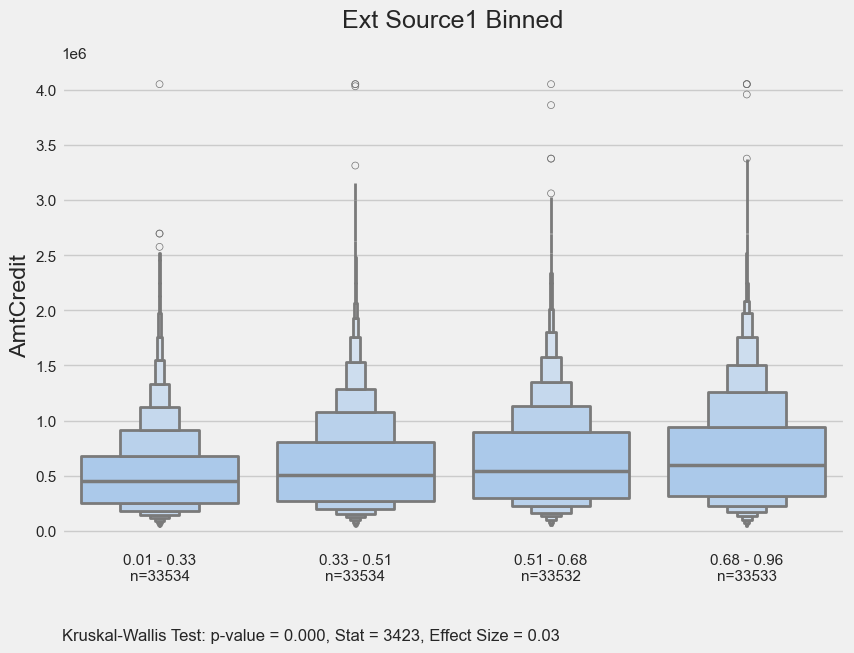

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


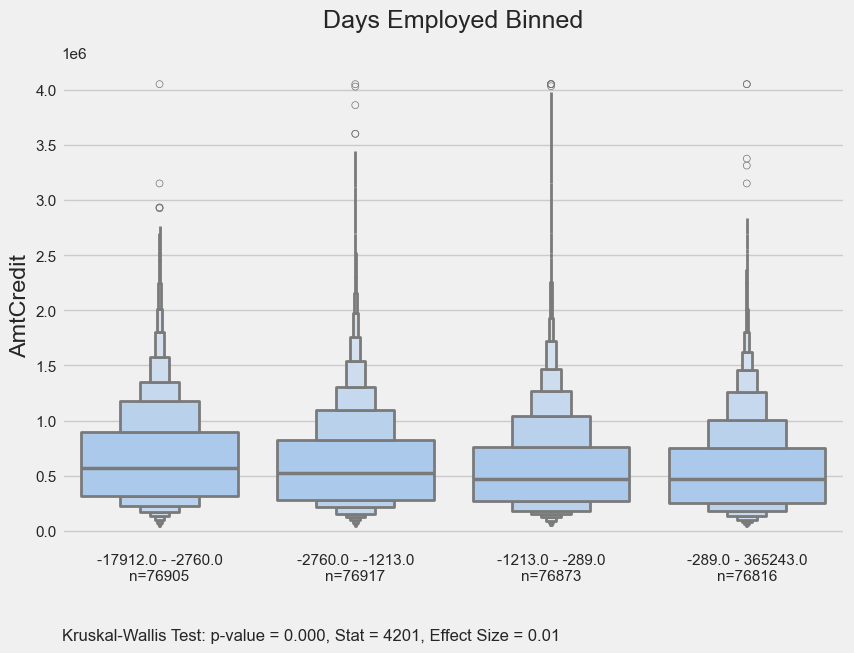

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


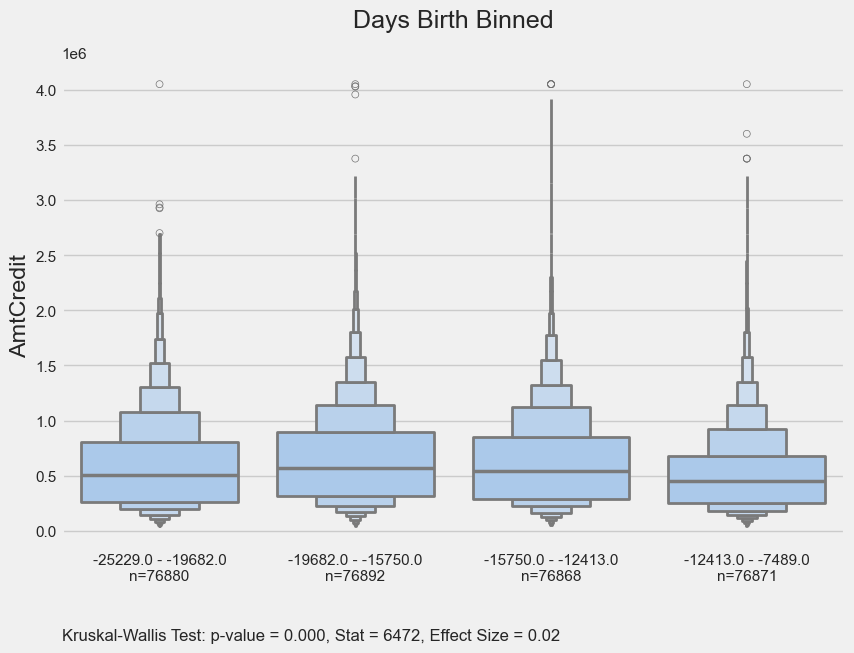

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


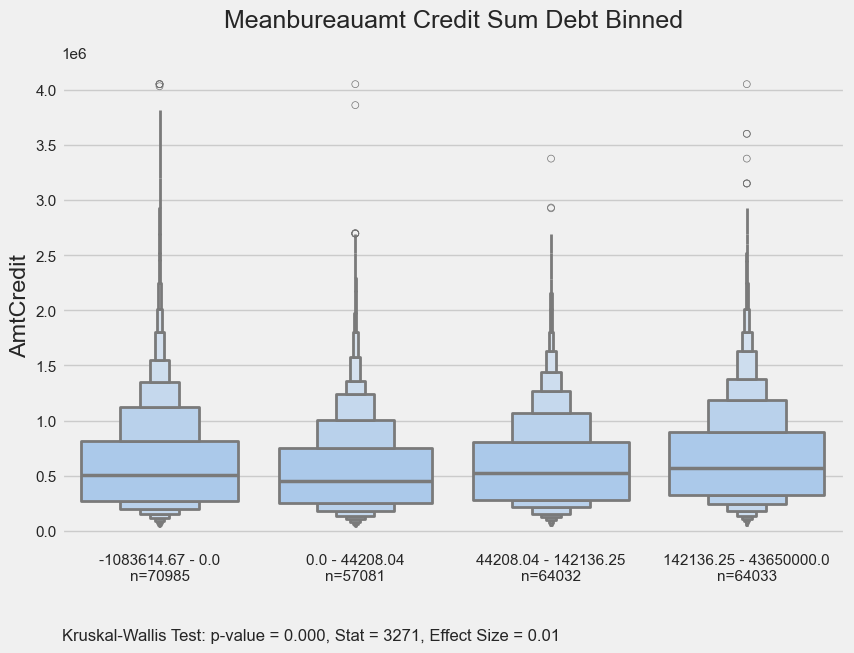

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


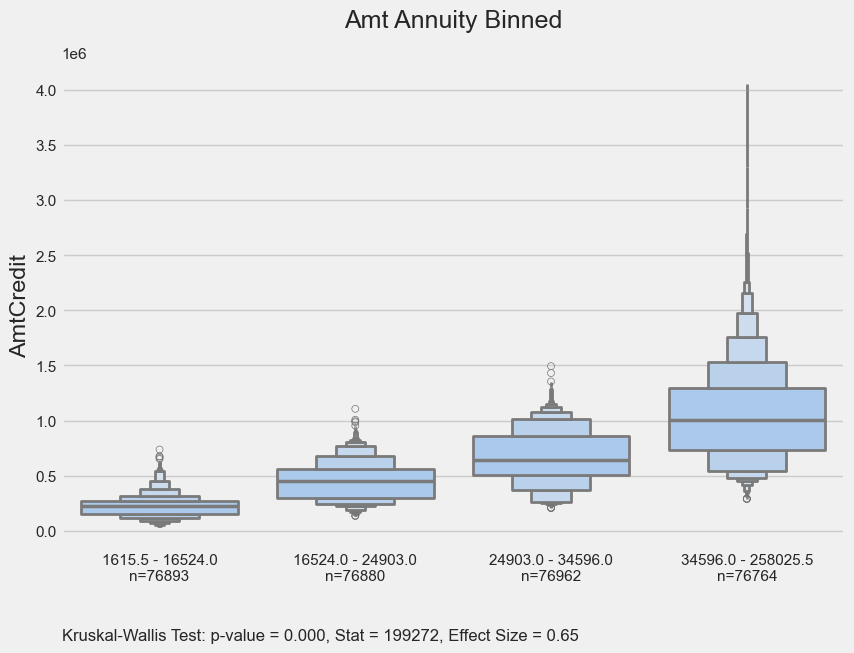

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


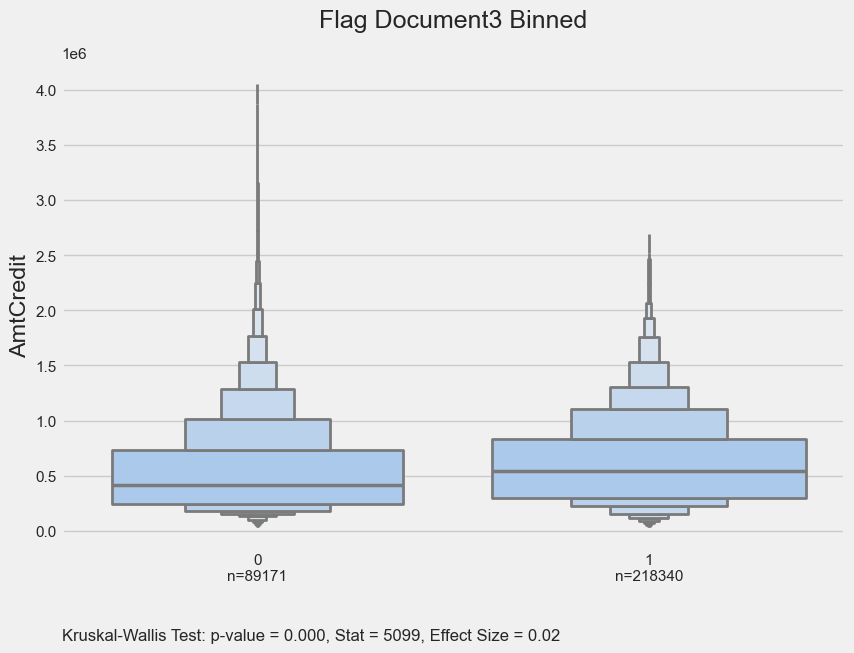

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


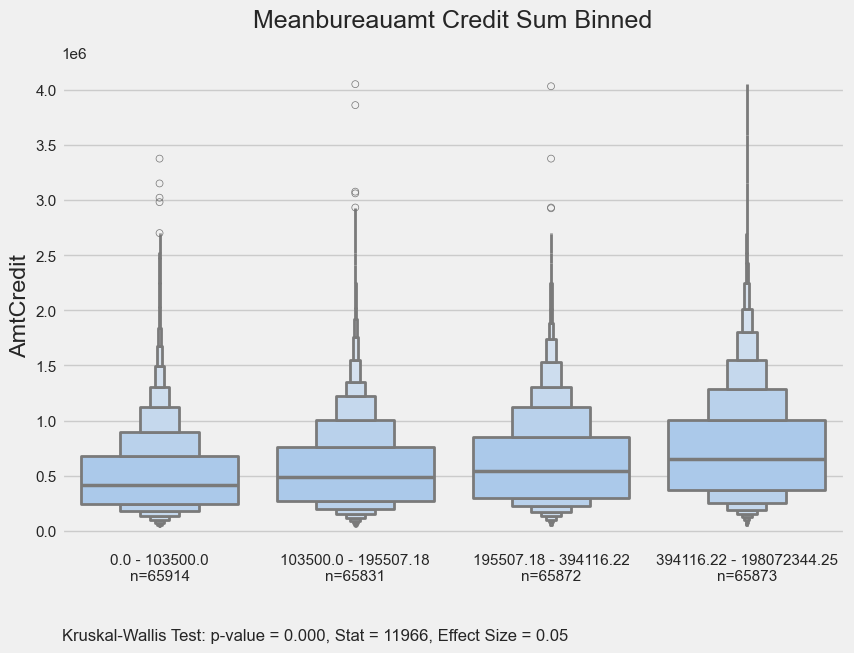

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


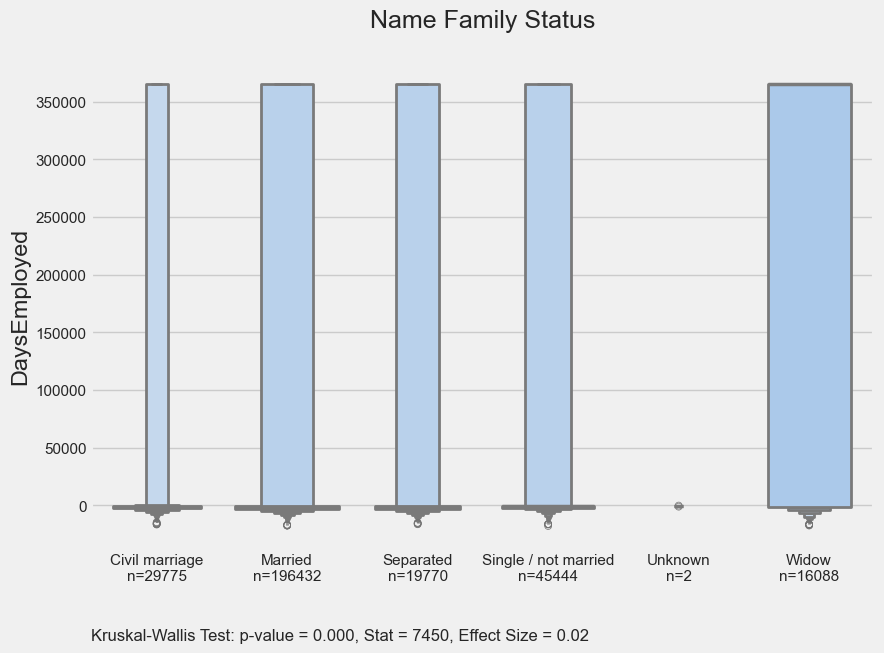

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


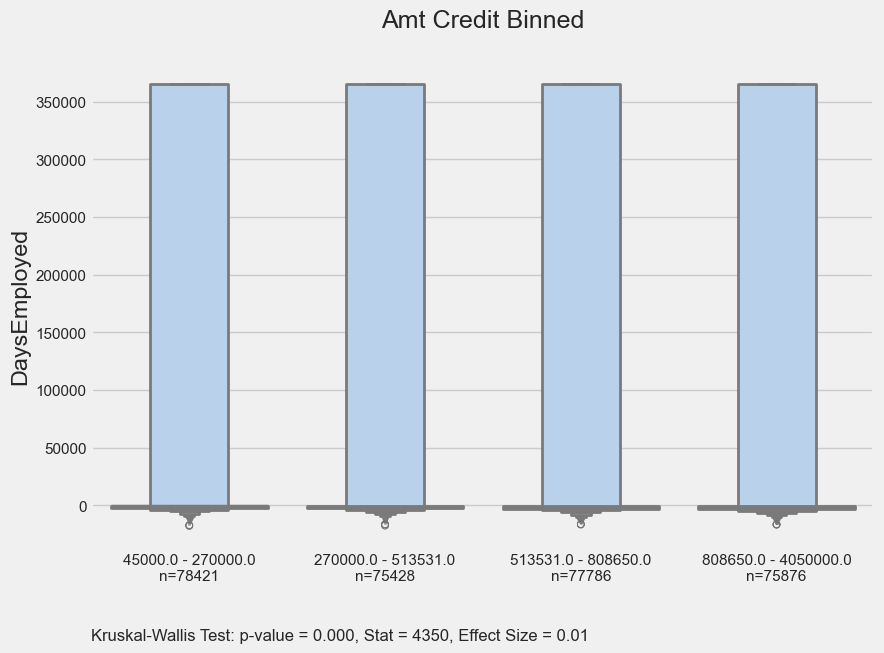

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


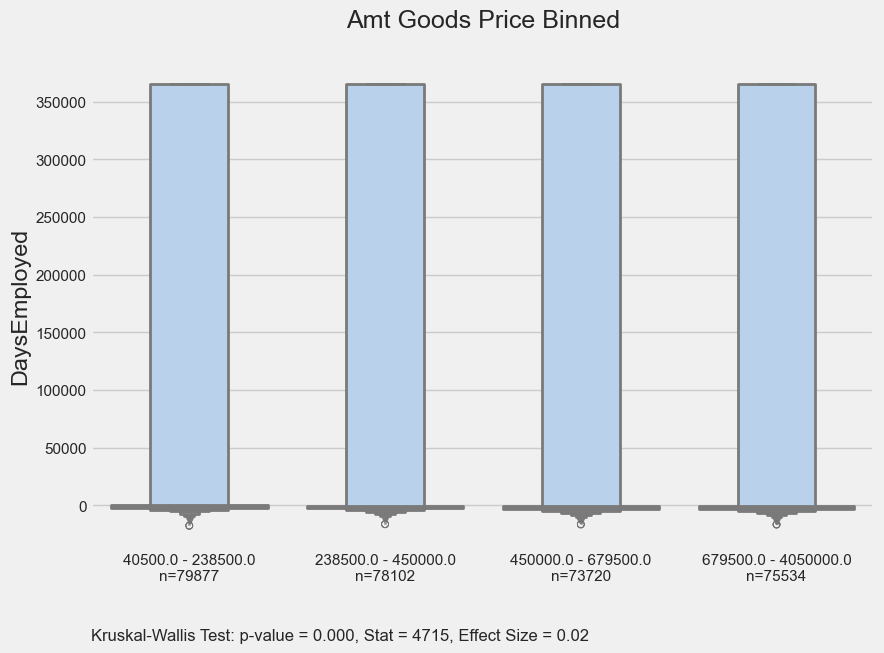

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


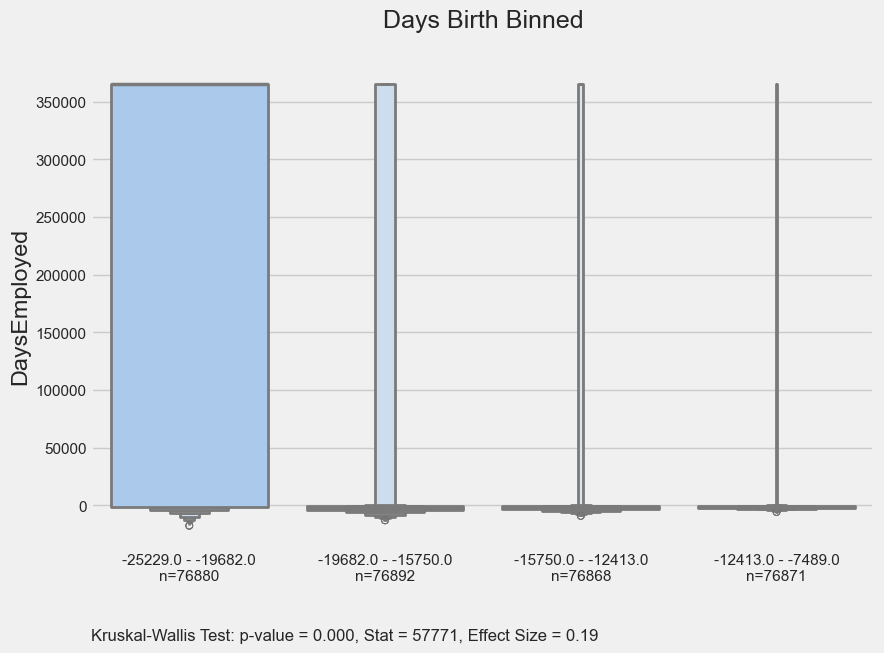

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


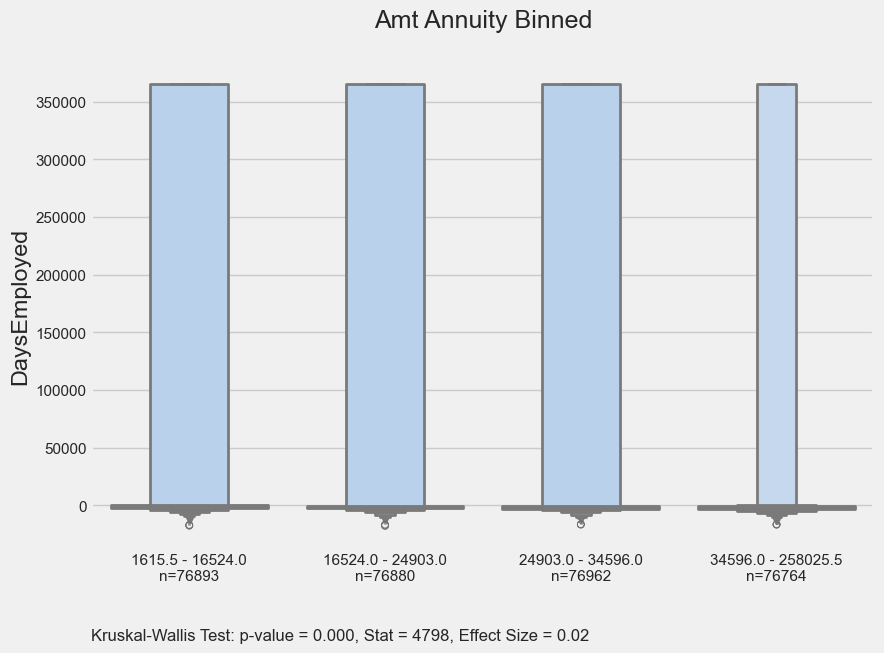

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


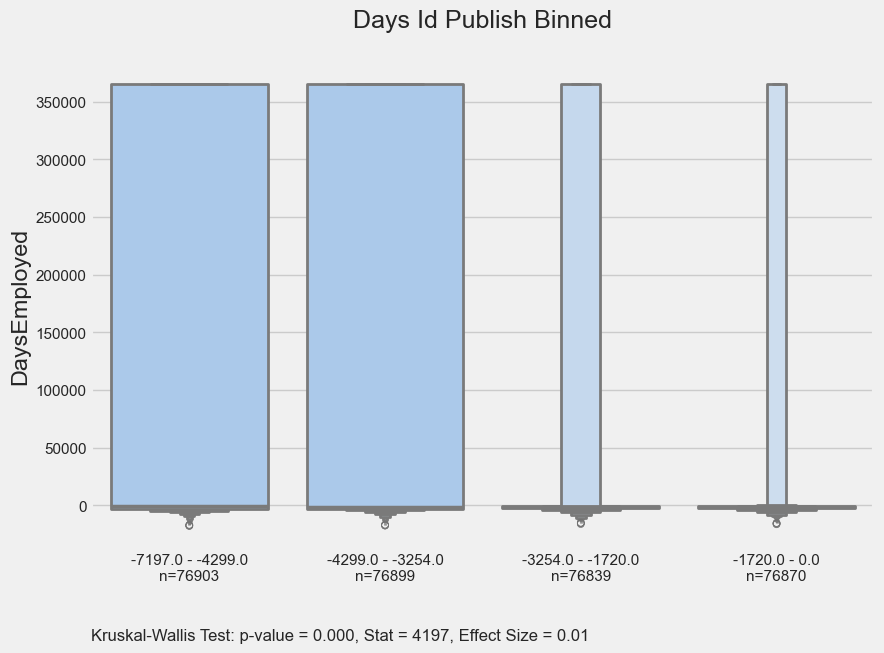

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


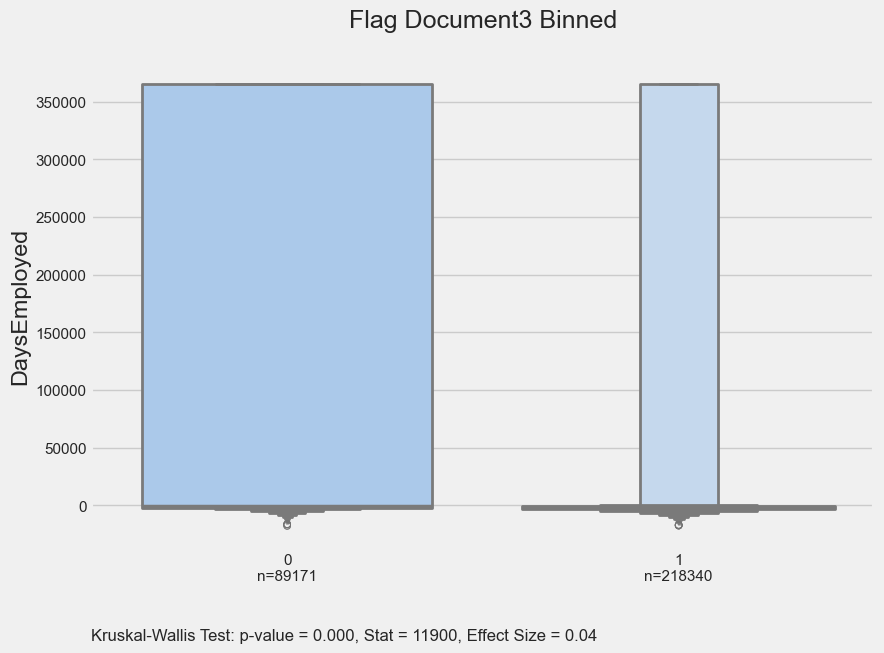

V:\projects\ppuodz-ML.4.1\shared\graph.py:1441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = _df.groupby(c)[y_target]
V:\projects\ppuodz-ML.4.1\shared\graph.py:1454: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = _df.groupby(c).size()


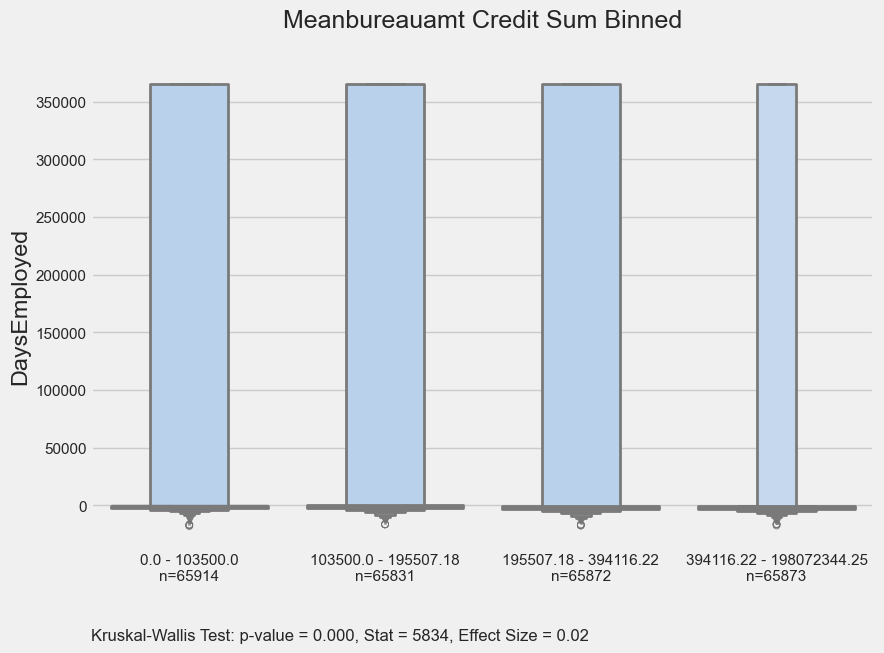

In [15]:
importlib.reload(graph)
for target_y in ["ExtSource2", "AmtCredit", "DaysEmployed"]:
    for c in features_matrix_with_bins.columns:
        if pd.api.types.is_numeric_dtype(features_matrix_with_bins[c]):
            continue

        if target_y in c and "binned" in c:
            continue

        if "ExtSource" in target_y and "ExtSource" in c:
            continue

        if features_matrix_with_bins[c].nunique() > 10:
            continue
        res = graph.boxen_plot_by_cat(c, features_matrix_with_bins, target_y)

        if res:
            display(res)

#### Analyzing Credit Scores (`ExtSource1`)

`ExtSource1/2/3` are the variables most strongly correlated with the target variable, they indicate client credit scores obtained from external sources. While th correlation coeficients are very low (only slightly above 0.1) we'll look a bit more into these scores because ussually credit ratings tend be the most useful metric when estimating the risk of specific loans:

C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2649400095.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", 4)


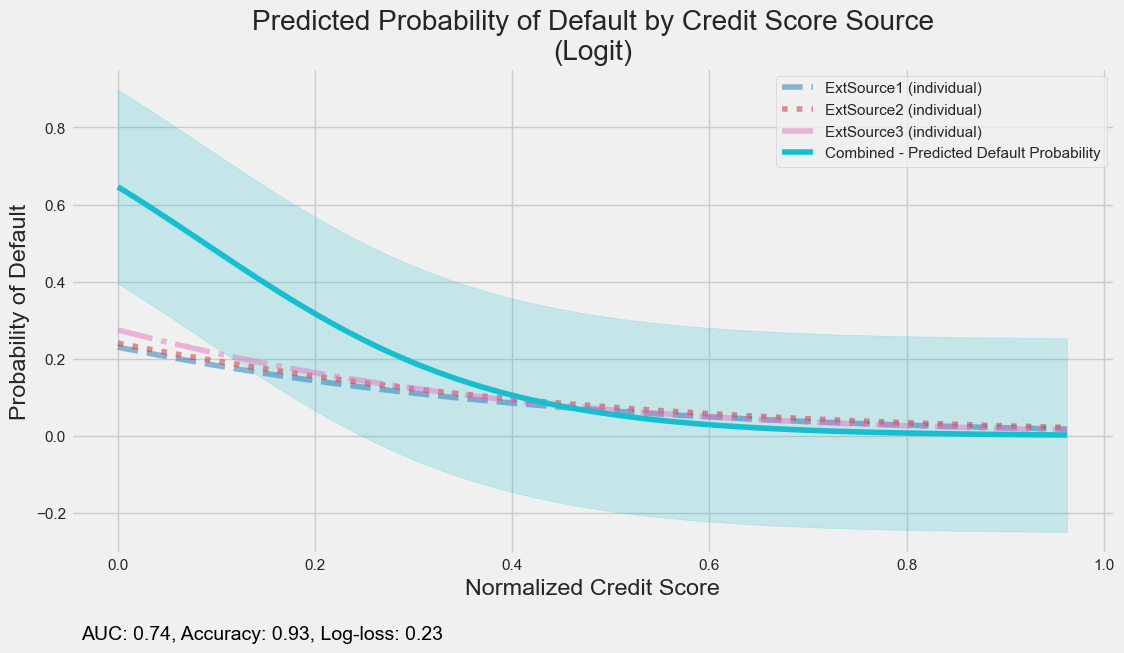

In [16]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

plt.figure(figsize=(12, 6))

line_styles = ["--", ":", "-."]

x_range = np.linspace(
    features_matrix[["ExtSource1", "ExtSource2", "ExtSource3"]].min().min(),
    features_matrix[["ExtSource1", "ExtSource2", "ExtSource3"]].max().max(),
    100,
)

predictions = {}

colors = plt.cm.get_cmap("tab10", 4)

for i, source in enumerate(["ExtSource1", "ExtSource2", "ExtSource3"]):
    subset = features_matrix[[source, "TARGET"]].dropna()
    X = sm.add_constant(subset[source])
    y = subset["TARGET"]

    model = sm.Logit(y, X).fit(disp=0)
    X_pred = pd.DataFrame({"const": 1, source: x_range})

    y_pred = model.predict(X_pred)
    predictions[source] = y_pred

    plt.plot(
        x_range,
        y_pred,
        color=colors(i),
        linestyle=line_styles[i],
        alpha=0.5,
        label=f"{source} (individual)",
    )

combined_features = features_matrix[
    ["ExtSource1", "ExtSource2", "ExtSource3", "TARGET"]
].dropna()
X_combined = sm.add_constant(
    combined_features[["ExtSource1", "ExtSource2", "ExtSource3"]]
)
y_combined = combined_features["TARGET"]

model_combined = sm.Logit(y_combined, X_combined).fit(disp=0)
X_pred_combined = pd.DataFrame(
    {"const": 1, "ExtSource1": x_range, "ExtSource2": x_range, "ExtSource3": x_range}
)

y_pred_combined = model_combined.predict(X_pred_combined)
y_pred_combined_for_metrics = model_combined.predict(X_combined)

predictions["Combined"] = y_pred_combined

residuals_combined = y_combined - model_combined.predict(X_combined)
residual_std_combined = np.std(residuals_combined)

combined_color = colors(3)
plt.plot(
    x_range,
    y_pred_combined,
    color=combined_color,
    label="Combined - Predicted Default Probability",
)
plt.fill_between(
    x_range,
    y_pred_combined - residual_std_combined,
    y_pred_combined + residual_std_combined,
    color=combined_color,
    alpha=0.2,
)

auc_combined = roc_auc_score(y_combined, y_pred_combined_for_metrics)
accuracy_combined = accuracy_score(
    y_combined, y_pred_combined_for_metrics.round()
)  # Assuming binary classification
logloss_combined = log_loss(y_combined, y_pred_combined_for_metrics)

metrics = f"AUC: {auc_combined:.2f}, Accuracy: {accuracy_combined:.2f}, Log-loss: {logloss_combined:.2f}"
plt.annotate(
    metrics, xy=(0.01, -0.175), xycoords="axes fraction", fontsize=14, color="black"
)

plt.title("Predicted Probability of Default by Credit Score Source\n(Logit)")
plt.xlabel("Normalized Credit Score")
plt.ylabel("Probability of Default")
plt.legend()
plt.show()

In [17]:
print(f"Summary for combined model:\n{model_combined.summary()}\n")  # Display summary

Summary for combined model:
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               109589
Model:                          Logit   Df Residuals:                   109585
Method:                           MLE   Df Model:                            3
Date:                Wed, 01 May 2024   Pseudo R-squ.:                  0.1047
Time:                        12:44:24   Log-Likelihood:                -25636.
converged:                       True   LL-Null:                       -28634.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6002      0.040     14.829      0.000       0.521       0.680
ExtSource1    -2.0989      0.061    -34.382      0.000      -2.219      -1.979
ExtSource2    -1.9640   

This is a simple Logistic model that just uses the credit scores to estimate the target variable. The confidence interval shows the the standard deviation of the residuals from a combined logistic regression model (residuals in this context are the differences between the observed values (y_combined) and the predicted probabilities).

Gennerally the explained variabity (Pseudo R-squared) is very quite low at only 0.1047 however the model itself is statistically significant (LLR p-value = 0.0)

In [18]:
model_params = model_combined.params
p_values = model_combined.pvalues
conf_int = model_combined.conf_int()
std_errors = model_combined.bse

coeff_df = pd.DataFrame(
    {
        "Coefficient": model_params,
        "Standard Error": std_errors,
        "P-Value": p_values,
        "Conf. Interval Lower": conf_int[0],
        "Conf. Interval Upper": conf_int[1],
    }
)
coeff_df.round(3)

Coefficient  Standard Error  P-Value  Conf. Interval Lower  Conf. Interval Upper
const             0.600           0.040      0.0                 0.521                 0.680
ExtSource1       -2.099           0.061      0.0                -2.219                -1.979
ExtSource2       -1.964           0.060      0.0                -2.082                -1.846
ExtSource3       -2.779           0.062      0.0                -2.902                -2.657

Normalized credit ratings from three sources are inversely related to default risk, with `ExtSource3` having the strongest influence. We can see that a basic Logistic model can already provide a reasonably high result (AUC = 0.74). However, we have to note that the results are based on the full training set and are only provided for EDA/feature analysis purposes. Full statistical modelling will be done in further sections.

C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\3414605899.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\3414605899.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


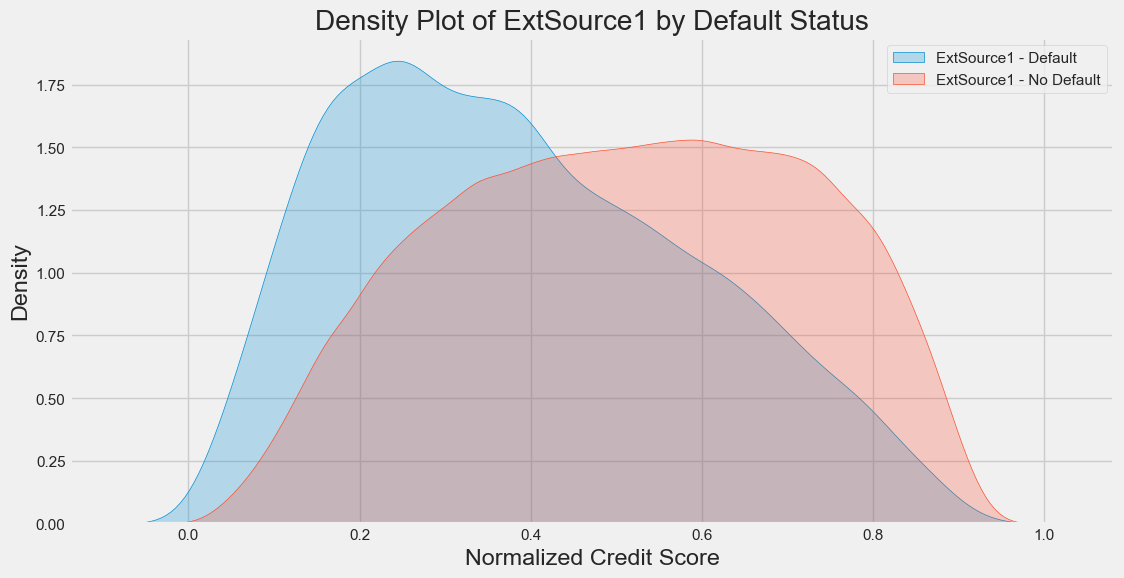

C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\3414605899.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\3414605899.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


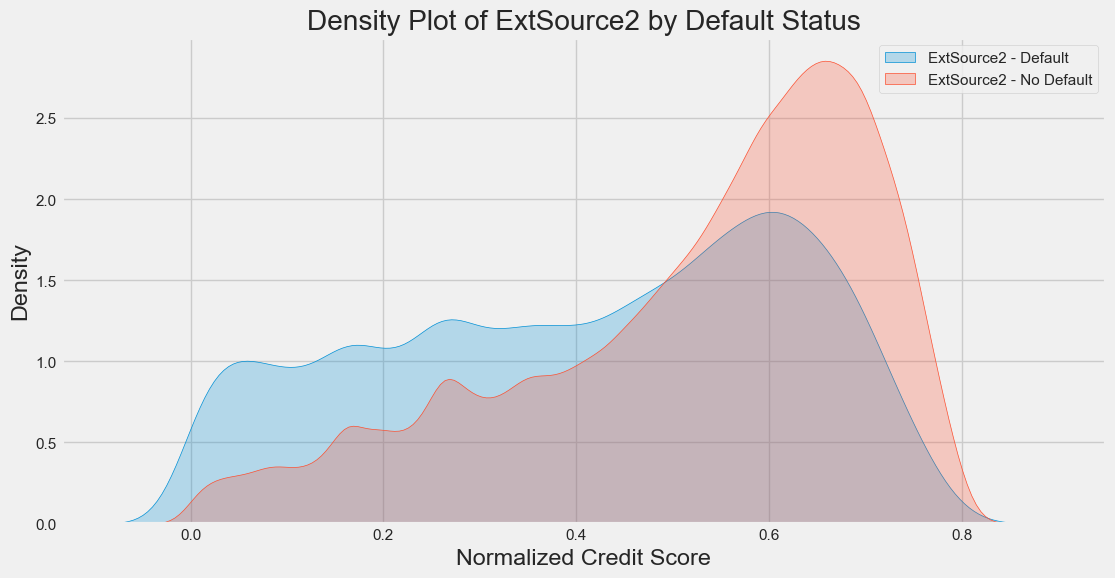

C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\3414605899.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\3414605899.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


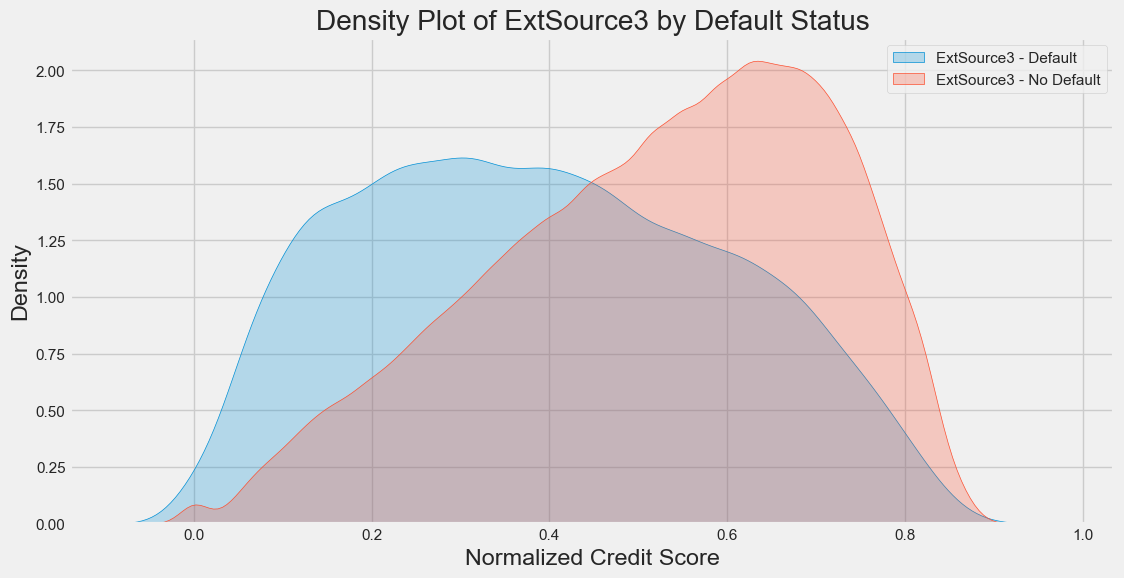

In [19]:
# Plotting
for i in range(1, 4):
    plt.figure(figsize=(12, 6))

    col = f"ExtSource{i}"
    sns.kdeplot(
        data=features_matrix[features_matrix["TARGET"] == 1][col],
        label=f"{col} - Default",
        shade=True,
    )
    sns.kdeplot(
        data=features_matrix[features_matrix["TARGET"] == 0][col],
        label=f"{col} - No Default",
        shade=True,
    )

    plt.title(f"Density Plot of ExtSource{i} by Default Status")
    plt.xlabel("Normalized Credit Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

We can see that while the the external credit are clearly related to default risk their explanatory power is somewhat limited because there is still a large amount of overlap (especially for ExtSource2, however it's coeefficient in our logistical model is similar to that of `ExtSource1`.

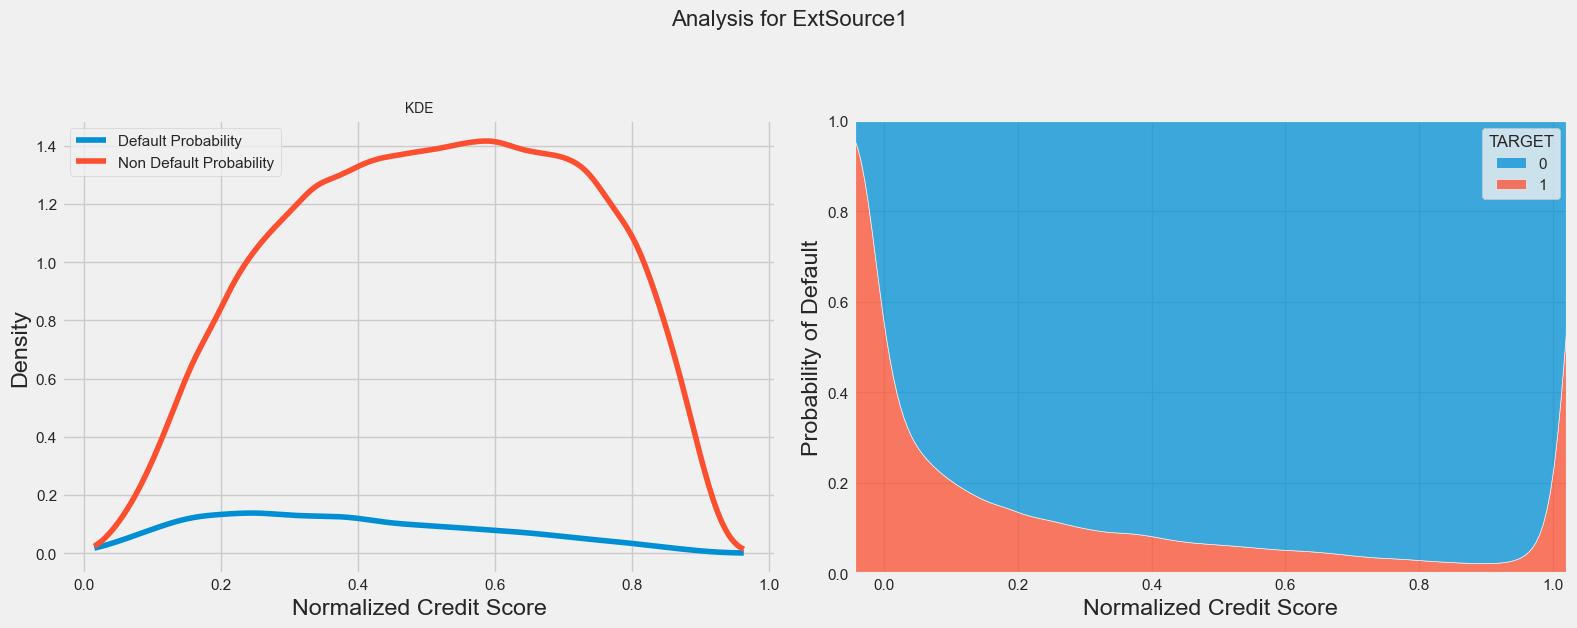

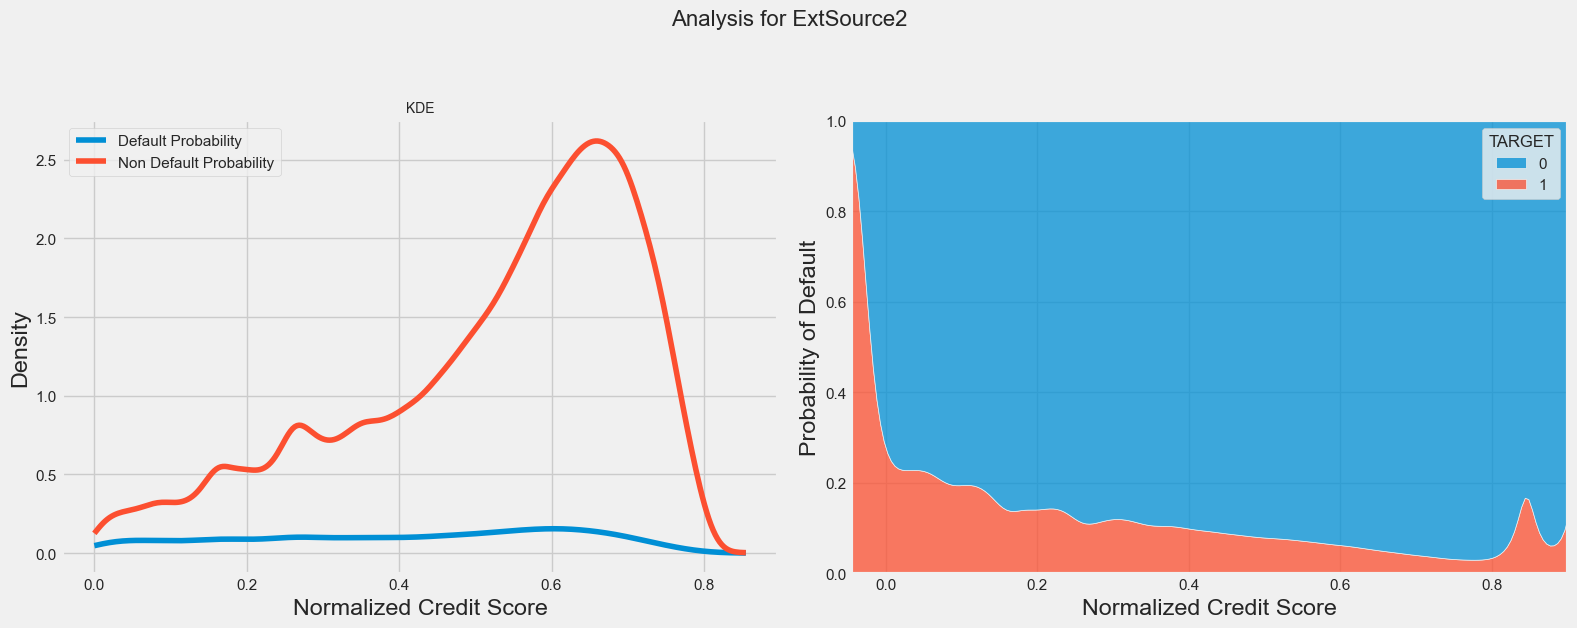

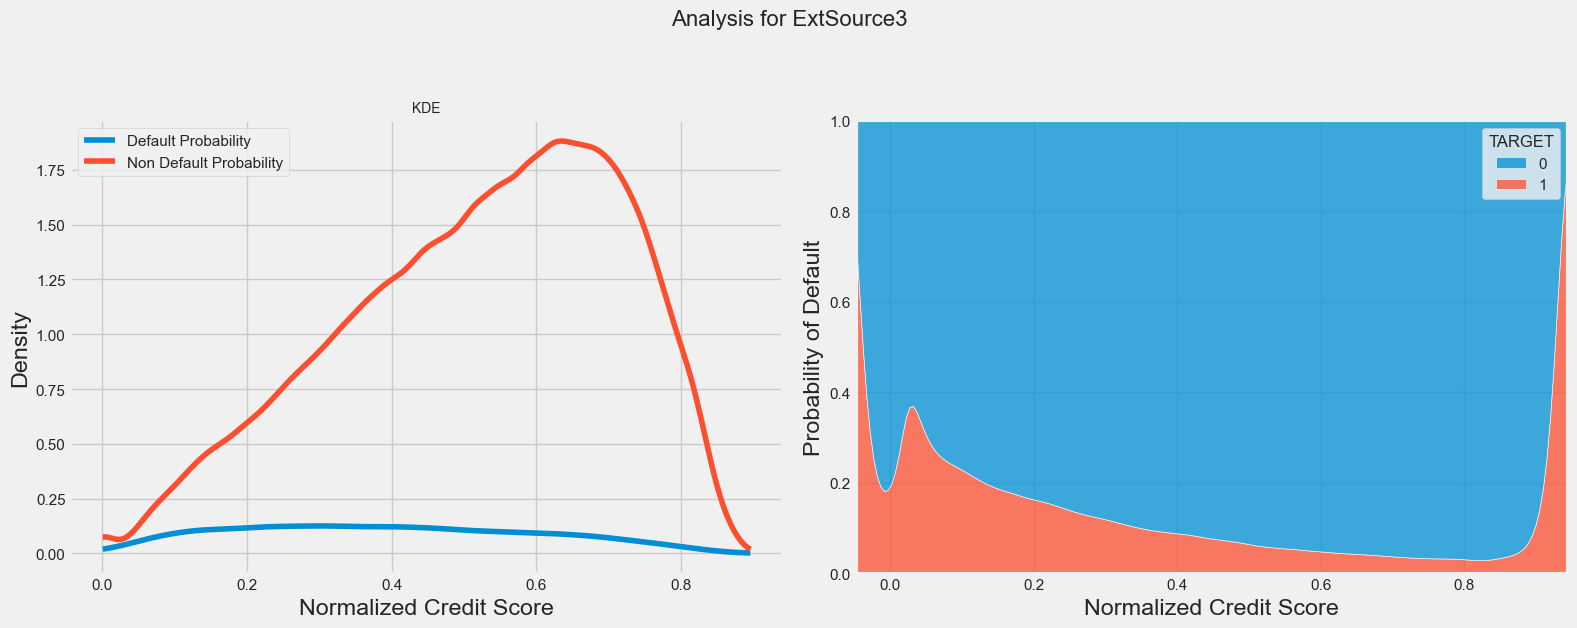

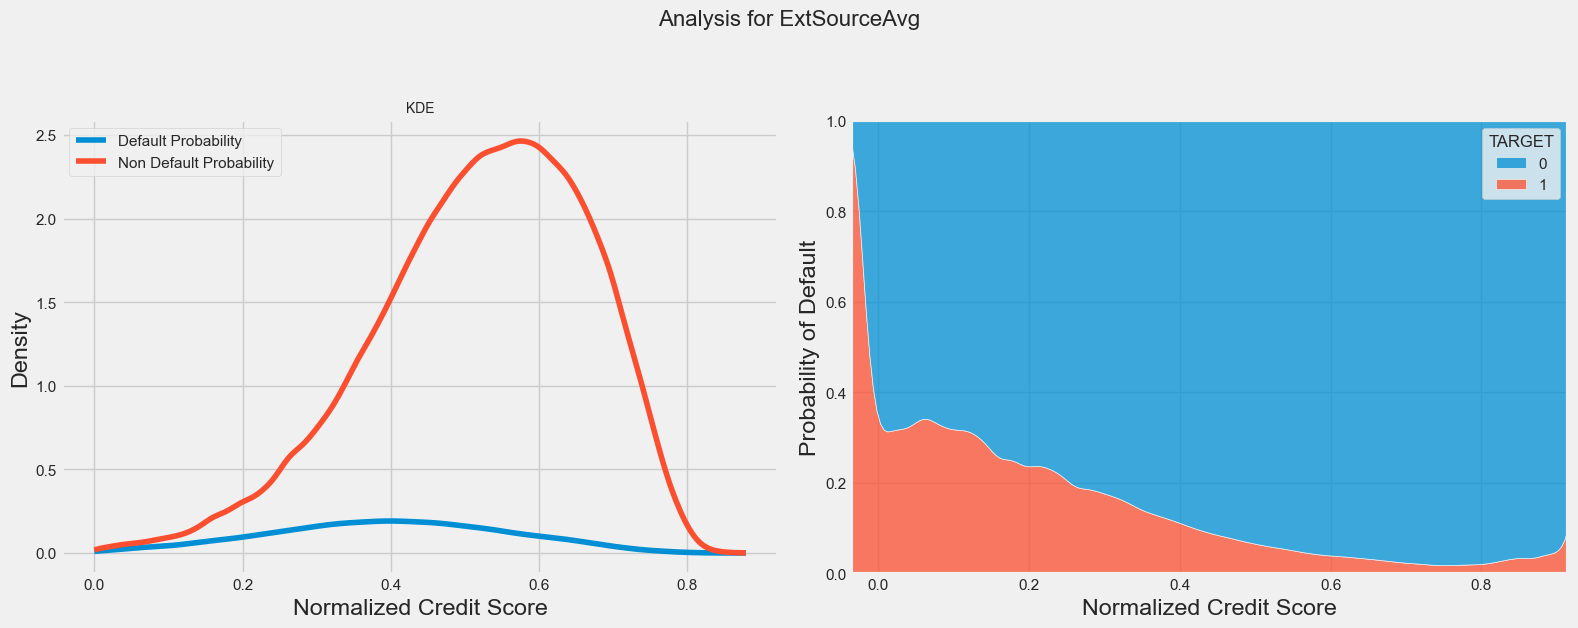

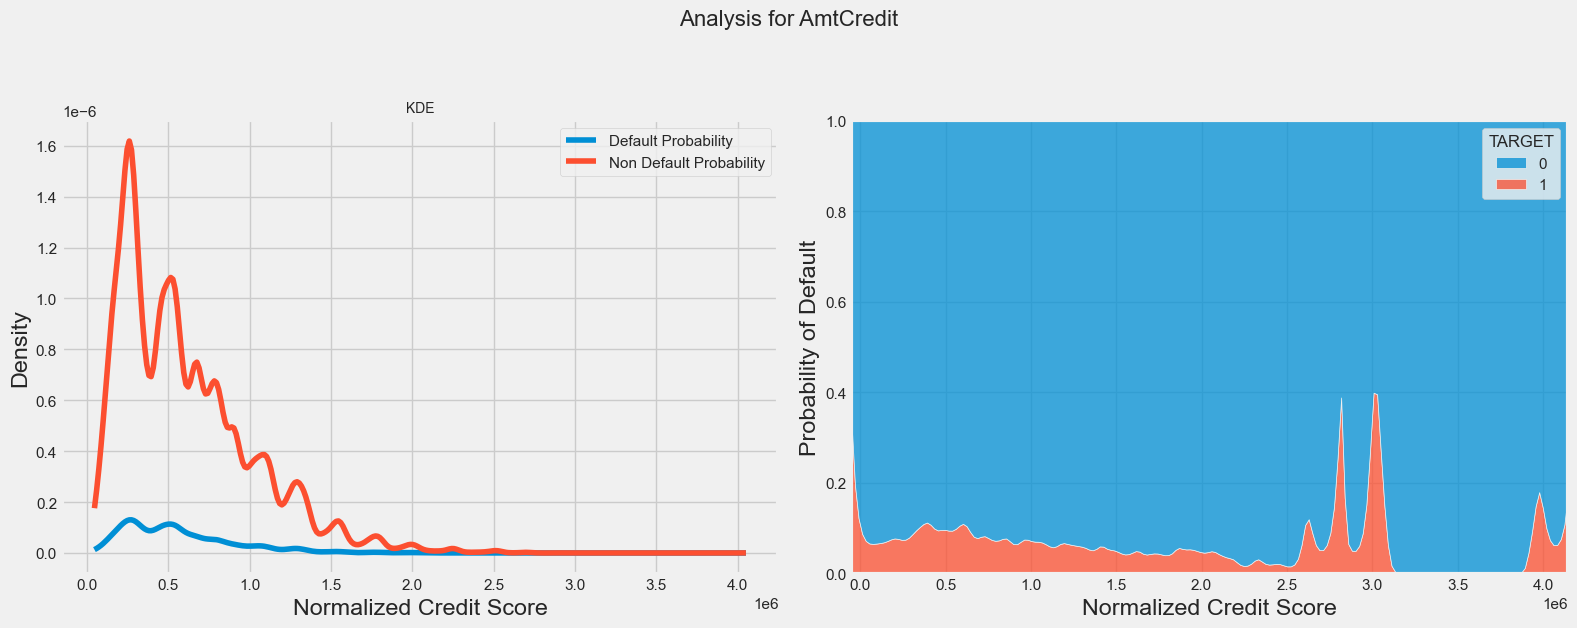

In [20]:
df = features_matrix[
    ["ExtSource1", "ExtSource2", "ExtSource3", "TARGET", "AmtCredit"]
].copy()

df["ExtSourceAvg"] = df[["ExtSource1", "ExtSource2", "ExtSource3"]].mean(
    axis=1, skipna=True
)

sources = ["ExtSource1", "ExtSource2", "ExtSource3", "ExtSourceAvg", "AmtCredit"]

for source in sources:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(f"Analysis for {source}", fontsize=16, y=1.05)  # Top-level title

    subset_default = df[df["TARGET"] == 1][source].dropna()
    subset_non_default = df[df["TARGET"] == 0][source].dropna()

    total_count = len(df[source].dropna())

    score_range = np.linspace(df[source].min(), df[source].max(), 300)

    kde_default = gaussian_kde(subset_default, bw_method="silverman")
    density_default = kde_default(score_range) * len(subset_default) / total_count

    kde_non_default = gaussian_kde(subset_non_default, bw_method="silverman")
    density_non_default = (
        kde_non_default(score_range) * len(subset_non_default) / total_count
    )

    sns.lineplot(x=score_range, y=density_default, ax=ax1, label="Default Probability")
    sns.lineplot(
        x=score_range, y=density_non_default, ax=ax1, label="Non Default Probability"
    )

    ax1.set_title(f"KDE", fontsize=10)  # Smaller font size for subplot title
    ax1.set_xlabel("Normalized Credit Score")
    ax1.set_ylabel("Density")
    ax1.legend()

    subset = df[[source, "TARGET"]].dropna()

    sns.kdeplot(
        data=subset,
        x=source,
        hue="TARGET",
        multiple="fill",
        ax=ax2,
    )

    ax2.set_xlabel("Normalized Credit Score")
    ax2.set_ylabel("Probability of Default")

    plt.tight_layout()
    plt.show()

##### Previous Application History

Did any clients had previously applied for loans with Home Credit and what were the outcomes of their applications?

In [21]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].value_counts()

PrevRatioRejectedAccepted_cats
All Accepted        190370
> 25% Rejected       66215
< 25% Rejected       34079
No Previous App.     16847
Name: count, dtype: int64

Did any applicants default on any previous loans?

In [22]:
features_matrix_with_bins["TotalDefaults_cats"].value_counts()

TotalDefaults_cats
No Defaults          304114
1 Defaulted Loans      3397
Name: count, dtype: int64

Suprisingly we can see that a ~1% of all applicants who were granted a loans have previously had payment difficulties with a previous loans at Home Credit. This is quite interesting considering that gennerally credit instituions are reluctant to offer  loans again to problematic clients.

Total "Defaults"/Loans With Payment Difficulties per applicant:

In [23]:
total_defaults_df = features_matrix["TotalDefaults"].value_counts().reset_index()
# Calculating the proportion and formatting it to two decimal places
total_defaults_df["proportion"] = (
    total_defaults_df["count"] / total_defaults_df["count"].sum()
).map("{:.3%}".format)

In [24]:
total_defaults_df

TotalDefaults   count proportion
0            0.0  304114    98.895%
1            1.0    3177     1.033%
2            2.0     163     0.053%
3            3.0      38     0.012%
4            4.0      11     0.004%
5            5.0       4     0.001%
6            6.0       3     0.001%
7            7.0       1     0.000%

### Previous Loan History and Default Risk

The chart below shows the default rate based on whether applicant has previous applied for loans with Home Cred:
`No Previous App.` - no previous applications for client found (i.e. new clients)
`All Accepted` - all previous applications were accepted
`< 25% Rejected` - less than 1/4 applications were rejected
`> 25% Rejected` - more than 1/4 applications were rejected

In [25]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].value_counts()

PrevRatioRejectedAccepted_cats
All Accepted        190370
> 25% Rejected       66215
< 25% Rejected       34079
No Previous App.     16847
Name: count, dtype: int64

Interestingly we can see that while applicants whose previous loans were rejected are significantly more likely to default when finally given a loan previous clients with no failed applications have a higher default risk than new clients.

This likely limits the usefulness of the `previous_application` table because only a small proportion of clients have previously rejected applications

In [26]:
features_matrix["AnyPreviousRejections"] = (
    features_matrix["PrevRatioRejectedAccepted"] > 0
)
features_matrix["AnyPreviousDefaults"] = features_matrix["TotalDefaults"] > 0

<Figure size 1000x600 with 0 Axes>

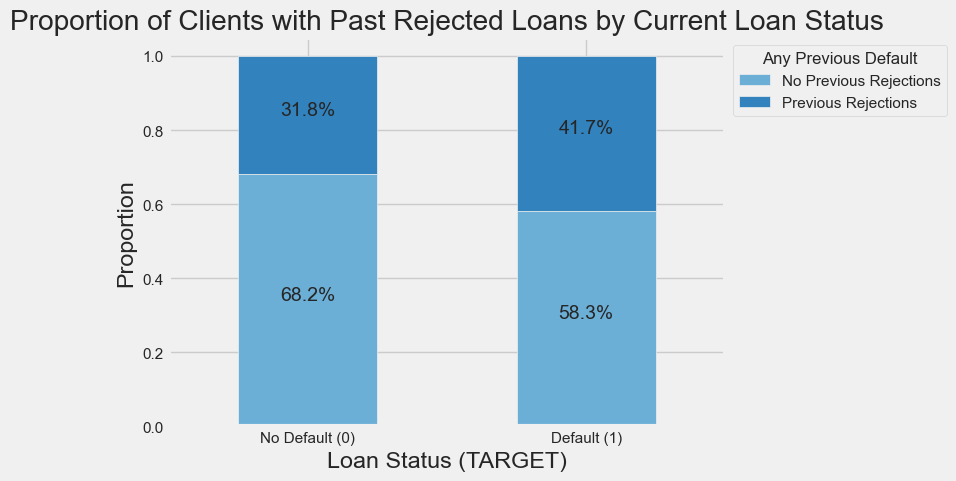

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

prop_df = (
    features_matrix.groupby("TARGET")["AnyPreviousRejections"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

plt.figure(figsize=(10, 6))
ax = prop_df.plot(kind="bar", stacked=True, color=["#6baed6", "#3182bd"])

plt.title("Proportion of Clients with Past Rejected Loans by Current Loan Status")
plt.xlabel("Loan Status (TARGET)")  # 0 for no default, 1 for default
plt.ylabel("Proportion")
plt.xticks(ticks=[0, 1], labels=["No Default (0)", "Default (1)"], rotation=0)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.annotate(f"{height:.1%}", (x + width / 2, y + height / 2), ha="center")

plt.legend(
    title="Any Previous Default",
    labels=["No Previous Rejections", "Previous Rejections"],
    loc="upper left",
    bbox_to_anchor=(1, 1),
)
plt.show()

C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2318662498.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2318662498.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


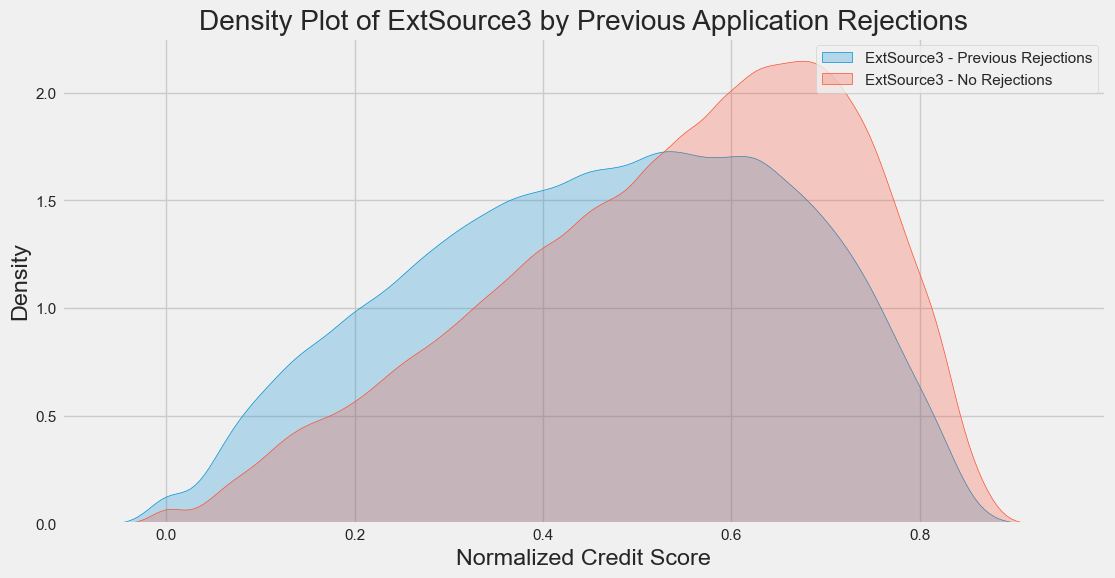

In [28]:
# Plotting
plt.figure(figsize=(12, 6))

col = f"ExtSource{i}"
sns.kdeplot(
    data=features_matrix[features_matrix["AnyPreviousRejections"] == 1][col],
    label=f"{col} - Previous Rejections",
    shade=True,
)
sns.kdeplot(
    data=features_matrix[features_matrix["AnyPreviousRejections"] == 0][col],
    label=f"{col} - No Rejections",
    shade=True,
)

plt.title(f"Density Plot of ExtSource{i} by Previous Application Rejections")
plt.xlabel("Normalized Credit Score")
plt.ylabel("Density")
plt.legend()
plt.show()

C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2778785946.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2778785946.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


<Figure size 1200x600 with 0 Axes>

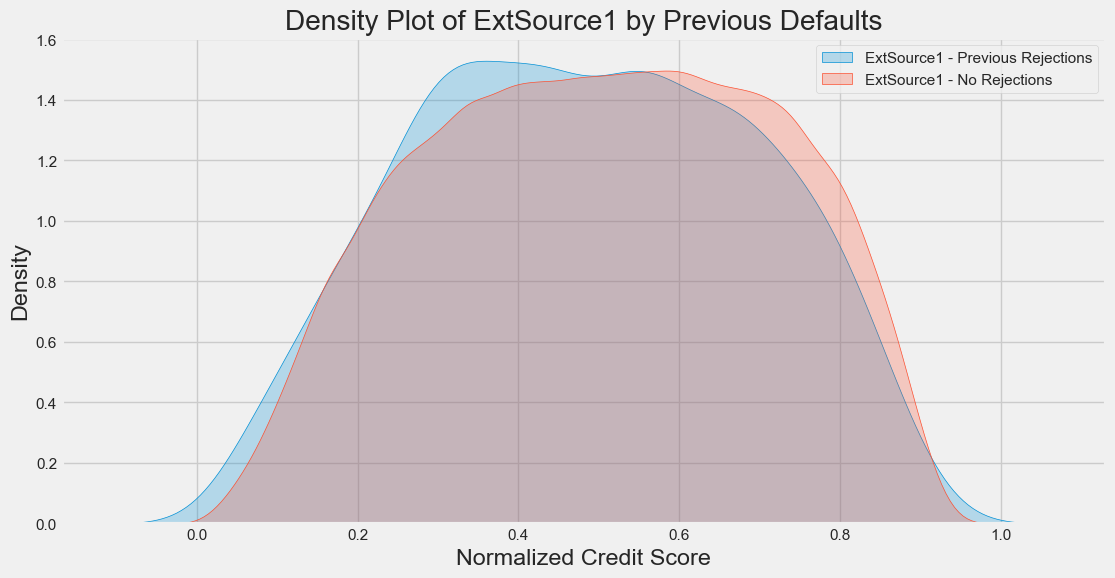

C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2778785946.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2778785946.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


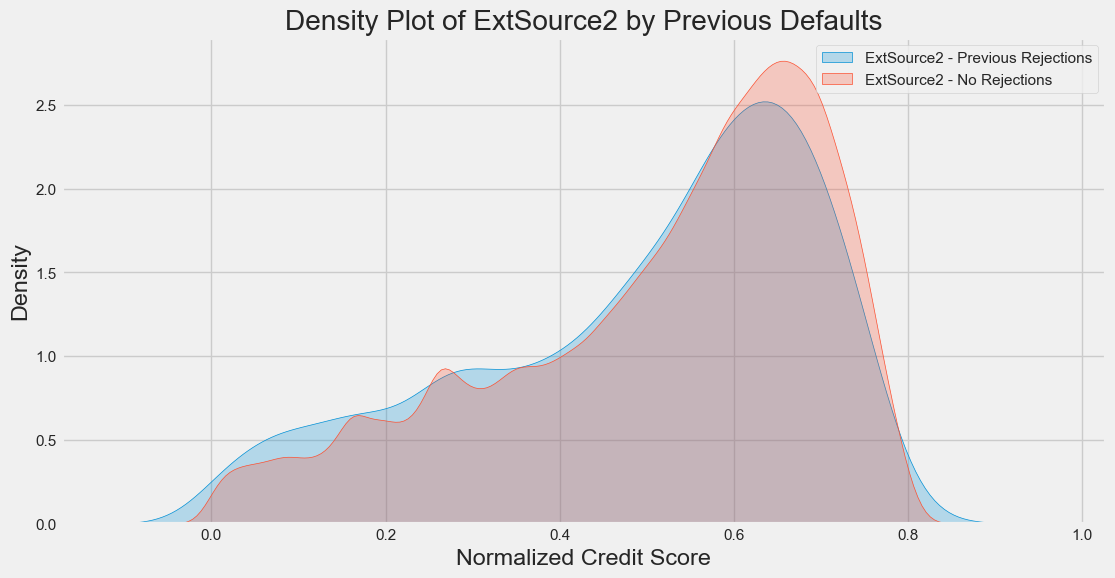

C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2778785946.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2778785946.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


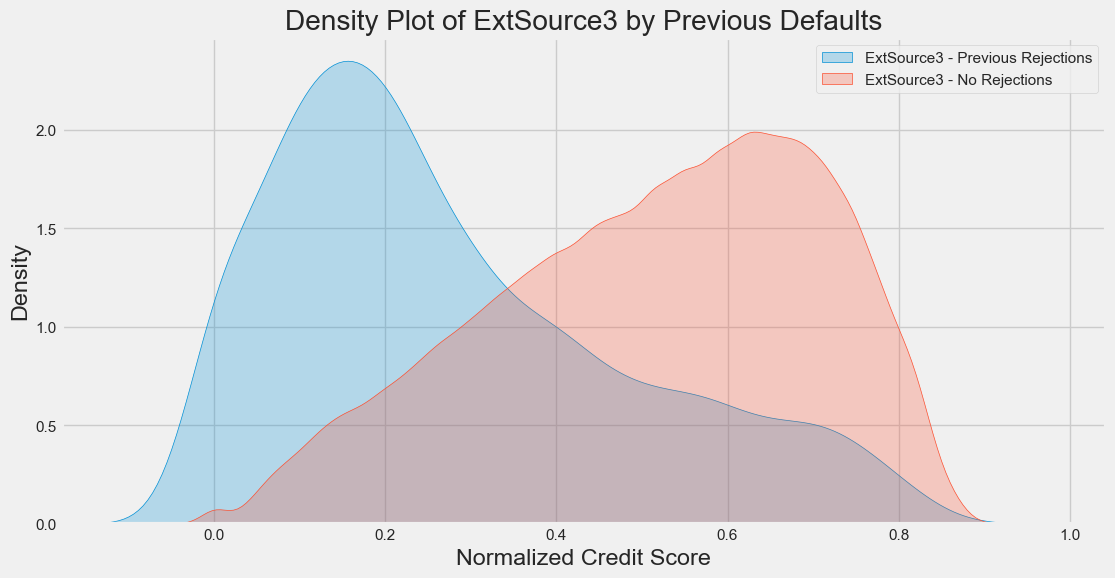

In [29]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting
for i in range(1, 4):
    plt.figure(figsize=(12, 6))

    col = f"ExtSource{i}"

    sns.kdeplot(
        data=features_matrix[features_matrix["AnyPreviousDefaults"] == 1][col],
        label=f"{col} - Previous Rejections",
        shade=True,
    )
    sns.kdeplot(
        data=features_matrix[features_matrix["AnyPreviousDefaults"] == 0][col],
        label=f"{col} - No Rejections",
        shade=True,
    )

    plt.title(f"Density Plot of ExtSource{i} by Previous Defaults")
    plt.xlabel("Normalized Credit Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

We can clearly see that clients who had run into payment issues with their past loans tend to have a signficantly lower credit `ExtSource3` however there is almost no difference with other scores. This incidates that the data from Home Credit itself is only included in the third rating (which might explain its higher explantatory power in our Logistic model)

#### Loan Purposes

V:\projects\ppuodz-ML.4.1\shared\graph.py:1511: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  source_df.groupby(group_col)[target_col]


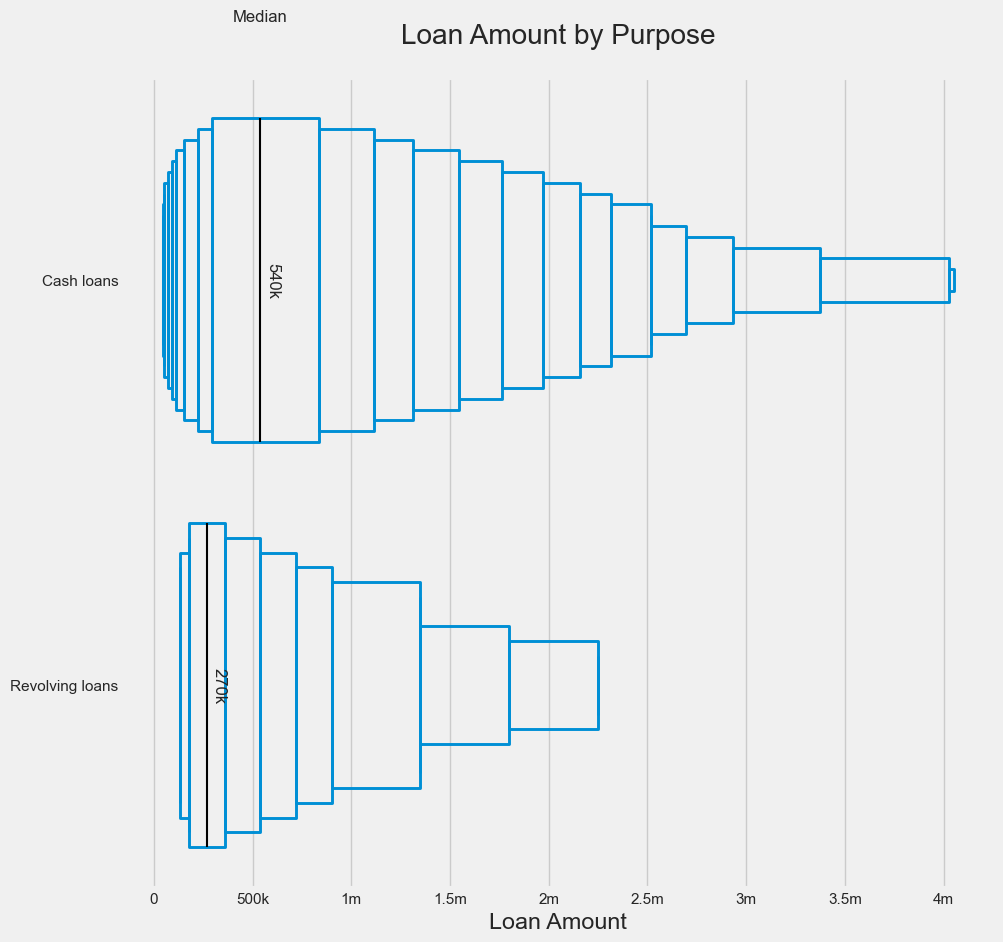

In [31]:
graph.boxen_plots_by_category(
    source_df=features_matrix,
    group_col="NameContractType",
    target_col="AmtCredit",
    title="Loan Amount by Purpose",
    x_label="Loan Amount",
)

C:\Users\Paulius\AppData\Local\Temp\ipykernel_18696\2838244680.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  features_matrix.groupby("NameContractType")["TARGET"]


<Figure size 1000x600 with 0 Axes>

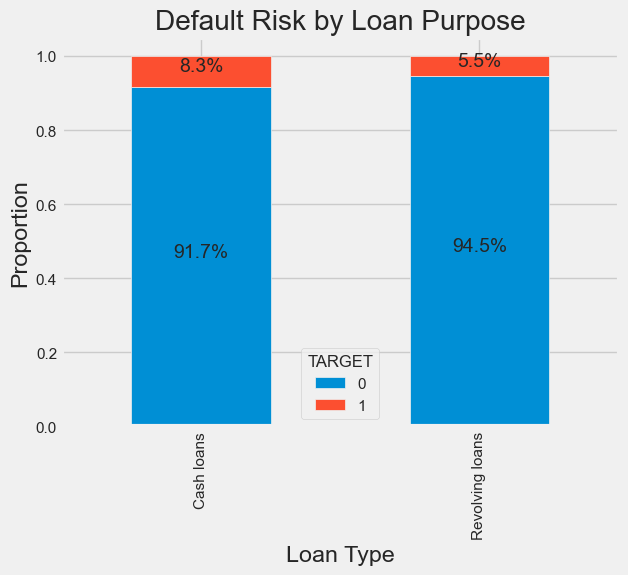

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

prop_df = (
    features_matrix.groupby("NameContractType")["TARGET"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

plt.figure(figsize=(10, 6))
ax = prop_df.plot(
    kind="bar",
    stacked=True,
)

plt.title("Default Risk by Loan Purpose")
plt.xlabel("Loan Type")  # 0 for no default, 1 for default
plt.ylabel("Proportion")

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.annotate(f"{height:.1%}", (x + width / 2, y + height / 2), ha="center")

plt.show()